---
## 2020 빅콘테스트 챔피언리그

DATE : 2020-08-02

ANALYST : Dongsam

PURPOSE : NS SHOP+ 판매실적 예측을 통한 편성 최적화 방안(모형) 도출

- NS Shop+편성데이터(NS홈쇼핑) 를 활용하여 방송편성표에 따른 판매실적을 예측
- 최적 수익을 고려한 요일별/ 시간대별 / 카테고리별 편성 최적화 방안(모형) 제시

### Variable Description
train.csv : 19년1월~19년12월 프로그램별 실적 데이터  

방송일시 : 방송일자 및 시간  
노출 (분) : 해당 상품의 방송 노출시간  
마더코드 : 유사 상품의 방송 코드  
상품코드 : 해당 상품의 상품 코드  
상품명 : 상품의 이름  
상품군 : 상품의 종류  
판매단가 : 개당 판매 단가  
**취급액 : 해당 방송분의 취급액 (판매단가 * 주문량)**  

sub.csv : 20년6월 프로그램별 분당실적 예측  

train.csv 데이터셋과 동일  

percent.csv : 요일별/시간대별 분단위 시청률 데이터 (단위 %)  

시간대 : 02시부터 익일 02시까지의 시간대  
2019-01-01 ~ 2020-01-01 : 해당 날짜의 시청률  
2019-01-01 to 2019-12-31 : _전체기간동안 해당 시간의 평균 시청률_  

※ 예측 상품 중 판매가 0인 프로그램 실적은 예측에서 제외함  

※ 예측 상품 중 과거 실적이 없는 경우는 유사 카테고리 혹은 동일머더코드로 예측함  



* 평가방법 
- 참가자들의 예측 결과물에 대한 성능 측정
- 모델 신뢰성 검증을 위한 평균 절대 비율 오차(MAPE : Mean Absolute Percentage Error) 사용


---
## OVERHEAD

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from pandas.tools.plotting import lag_plot
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
import matplotlib
from matplotlib import font_manager, rc
import platform
#from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from konlpy.tag import Twitter 
from collections import Counter
from IPython.display import set_matplotlib_formats
#import folium
pd.set_option('display.max_columns', 200)

In [342]:
#한글폰트 설정
if platform.system() == 'Windows':
    from matplotlib import font_manager, rc
    import platform
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    font_fname = '/Users/eastone/Library/Fonts/NotoSansCJKkr-Regular.otf'
    font_name = font_manager.FontProperties(fname=font_fname).get_name()
    rc('font', family=font_name)

    plt.rcParams["font.family"] = 'NanumSquare_ac'

In [2]:
df = pd.read_csv('../bigcon/train.csv', encoding='CP949',thousands = ',')
#취급액의 천단위 comma 제거

In [ ]:
from matplotlib import font_manager, rc
import platform
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

19-20년도 데이터 읽어오기

In [140]:
sub = pd.read_csv('/Users/eastone/Downloads/2020빅콘테스트 문제데이터(데이터분석분야-챔피언리그)_update_200818 (1)/02_평가데이터/sub.csv')
sub.tail()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
2886,2020.7.1 0:20,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2887,2020.7.1 0:40,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2888,2020.7.1 1:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2889,2020.7.1 1:20,20.0,100261,200875,아놀드파마 티셔츠레깅스세트,의류,"69,900",NaN
2890,2020.7.1 1:40,16.0,100261,200875,아놀드파마 티셔츠레깅스세트,의류,"69,900",NaN


20년도 06월 데이터 읽어오기

In [3]:
percent = pd.read_csv('../data/bigcon/percent.csv', encoding='CP949')
percent.head()

,시간대,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,...,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2019-01-01 to 2019-12-31
0,02:00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.003
1,02:01,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.012,0.003
2,02:02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.004
3,02:03,0.0,0.0,0.014,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.000,0.004
4,02:04,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.000,0.004


시청률 데이터 읽어오기

---
# EDA



## 2019-01-01 ~ 2019-12-31 데이터 : df

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   방송일시    38309 non-null  object 
 1   노출(분)   21525 non-null  float64
 2   마더코드    38309 non-null  int64  
 3   상품코드    38309 non-null  int64  
 4   상품명     38309 non-null  object 
 5   상품군     38309 non-null  object 
 6   판매단가    38309 non-null  object 
 7    취급액    37372 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.3+ MB


8개의 컬럼, 38309개의 행
- 노출(분) 컬럼의 경우 NaN값이 다수 존재하는 것 파악
- 판매단가 및 취급액의 경우 연속형 변수임에도 object 타입인 것 파악
- 방송일시 컬럼은 날짜형 데이터 타입으로 변환 필요 

In [16]:
df.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 6:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","2,099,000"
1,2019-01-01 6:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","4,371,000"
2,2019-01-01 6:20,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","3,262,000"
3,2019-01-01 6:20,NaN,100346,201079,테이트 여성 셀린니트3종,의류,"39,900","6,955,000"
4,2019-01-01 6:40,20.0,100346,201072,테이트 남성 셀린니트3종,의류,"39,900","6,672,000"


df 데이터프레임의 내용 확인

In [32]:
df['상품군'].value_counts()

주방      6604
가전      6479
의류      4340
속옷      3919
잡화      3891
농수축     3884
생활용품    2877
가구      2614
이미용     1305
무형       937
건강기능     790
침구       669
Name: 상품군, dtype: int64

각 상품군 별 분포도 확인 (시각화)

In [17]:
df['노출(분)'].unique()

array([20., nan, 30., 17., 27., 16., 26., 60., 12.,  2., 15., 25.,  3.,
       14., 22., 10., 13., 23., 18.,  5.,  9., 19.,  7., 11., 40.])

각 상품별 상이한 노출시간 존재 NaN 값 역시 존재함을 확인

## 2020-06 데이터 : sub

In [11]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   방송일시    2891 non-null   object 
 1   노출(분)   1780 non-null   float64
 2   마더코드    2891 non-null   int64  
 3   상품코드    2891 non-null   int64  
 4   상품명     2891 non-null   object 
 5   상품군     2891 non-null   object 
 6   판매단가    2891 non-null   object 
 7   취급액     0 non-null      float64
dtypes: float64(2), int64(2), object(4)
memory usage: 180.8+ KB


sub 데이터 프레임 확인. df 데이터프레임과 컬럼수는 같으며 노출 컬럼에 Null 값이 많이 존재하는 것 확인

## 시청률데이터 : percent

In [13]:
percent.tail()

,시간대,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,...,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2019-01-01 to 2019-12-31
1436,01:56,0.000,0.000,0.000,0.000,0.027,0.000,0.000,0.000,0.000,...,0.013,0.000,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.004
1437,01:57,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,...,0.013,0.000,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.004
1438,01:58,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,...,0.013,0.017,0.000,0.000,0.015,0.000,0.000,0.019,0.000,0.004
1439,01:59,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,...,0.013,0.000,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.004
1440,월화수목금토일02:00-01:59,0.004,0.006,0.002,0.003,0.002,0.003,0.003,0.002,0.003,...,0.010,0.006,0.006,0.007,0.004,0.006,0.004,0.005,0.005,0.004


시청률데이터
- 날짜가 컬럼으로 정렬되어 있다.
- 1분단위 시계열 데이터로 구성

In [15]:
percent.describe()

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2019-01-01 to 2019-12-31
count,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,...,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000
mean,0.003681,0.005564,0.001731,0.002658,0.002079,0.002858,0.002703,0.002152,0.002730,0.001947,...,0.010427,0.006006,0.006026,0.006806,0.003879,0.006118,0.004477,0.004576,0.004910,0.004297
std,0.008067,0.012898,0.006213,0.008908,0.007124,0.008478,0.006594,0.006987,0.008164,0.008277,...,0.015119,0.012908,0.012975,0.013342,0.009357,0.012180,0.010604,0.010783,0.013289,0.001512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004000
75%,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013000,0.012000,0.002000,0.010000,0.000000,0.007000,0.000000,0.000000,0.000000,0.005000
max,0.069000,0.073000,0.073000,0.059000,0.070000,0.081000,0.039000,0.078000,0.049000,0.089000,...,0.077000,0.118000,0.095000,0.108000,0.080000,0.093000,0.075000,0.069000,0.108000,0.008000


시청률 데이터 통계치 확인

## EDA 를 통해 얻은 인사이트
- 취급액 / 판매단가로 주문량 변수 추가하기
- 방송일시를 년 월 일 시간 등 세부 단위로 분할
- 노출이 nan인 경우 다른 상품 판매시 끼워팔기? 같은식으로 판매진행한듯 
    - 예를들어 테이트 남성니트의 판매 방송에 여성니트는 노출되지 않았지만 판매는 동시진행
- 상품명을 통해 남성/여성 제품인지 따로 분류할 수 있는 정보 탐색
- 시청률에따른 판매변화 확인
- 20년 06년 시청률 예측을 위해 시계열 트렌드 관련 지표 사용(슬로프, LSTM 등)

In [3]:
#컬럼명 영어로 치환
df.rename(columns = {'방송일시':'date', '노출(분)':'exposure','마더코드':'mother_code',
                    '상품코드':'product_code','상품명':'product_name','상품군':'product_kind',
                    '판매단가':'price_per_unit',' 취급액 ':'total_price'},inplace=True)

In [6]:
#취급액 컬럼의 , 와 결측치를 0으로 대체
df['total_price'] = df['total_price'].fillna(0).astype('float')

In [141]:
#sub 데이터프레임의 컬럼명 영어 치환
sub.rename(columns = {'방송일시':'date', '노출(분)':'exposure','마더코드':'mother_code',
                    '상품코드':'product_code','상품명':'product_name','상품군':'product_kind',
                    '판매단가':'price_per_unit','취급액':'total_price'},inplace=True)

In [284]:
df.columns

Index(['date', 'exposure', 'mother_code', 'product_code', 'product_name',
       'product_kind', 'price_per_unit', 'total_price'],
      dtype='object', name=0)

한글로 되어있던 컬럼명을 편의를 위해 영어로 치환

In [7]:
df['price_per_unit'] = df['price_per_unit'].str.strip()
df['price_per_unit'] = df['price_per_unit'].str.replace(',','')
df['price_per_unit'] = df['price_per_unit'].str.replace('-','0')
df['price_per_unit']  =df['price_per_unit'].astype('int64')


In [142]:
sub['price_per_unit'] = sub['price_per_unit'].str.strip()
sub['price_per_unit'] = sub['price_per_unit'].str.replace(',','')
sub['price_per_unit'] = sub['price_per_unit'].str.replace('-','0')
sub['price_per_unit']  =sub['price_per_unit'].astype('int64')


price_per_unit 컬럼을 숫자형으로 변경

In [8]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['time'] = df['date'].dt.time
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

df.head()

,date,exposure,mother_code,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019,1,1,06:00:00,6,0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019,1,1,06:00:00,6,0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019,1,1,06:20:00,6,20
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019,1,1,06:20:00,6,20
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019,1,1,06:40:00,6,40


In [143]:
sub['date'] = pd.to_datetime(sub['date'], format = '%Y-%m-%d %H:%M')
sub['year'] = sub['date'].dt.year
sub['month'] = sub['date'].dt.month
sub['day'] = sub['date'].dt.day
sub['time'] = sub['date'].dt.time
sub['hour'] = sub['date'].dt.hour
sub['minute'] = sub['date'].dt.minute

sub.head()

,date,exposure,mother_code,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,06:20:00,6,20
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,06:40:00,6,40
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,07:00:00,7,0
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,1,07:20:00,7,20
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,1,07:40:00,7,40


date 컬럼을 년 월 일 시 분 으로 나누기

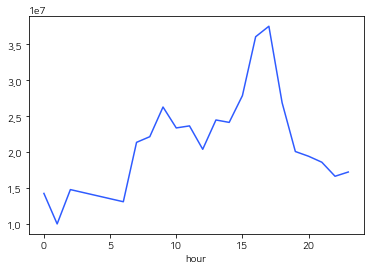

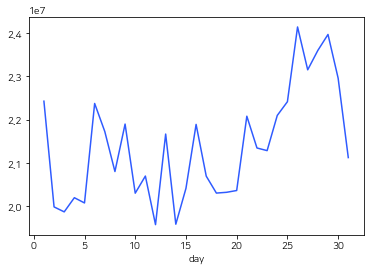

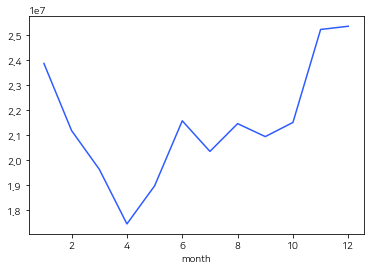

In [124]:
df.groupby('hour').mean()['total_price'].plot(color ='#2f5bff')
plt.show()
df.groupby('day').mean()['total_price'].plot(color ='#2f5bff')
plt.show()
df.groupby('month').mean()['total_price'].plot(color ='#2f5bff')
plt.show()

시간대 별 매출액 평균 그래프.
저녁 시간대에 매출이 높아지는 것을 확인

상품군 별 매출액, 주문량의 평균 그래프.
농수축 이미용의 경우 큰 차이는 없으나 판매단가가 높은 가구, 가전의 경우 주문량이 현저히 낮다

## 주문량 변수 생성

In [9]:
#취급액/개당가격 을 통해 주문량 변수 생성
df['order_quantity'] = round(df['total_price']/df['price_per_unit'])

Text(0, 0.5, 'Product kind')

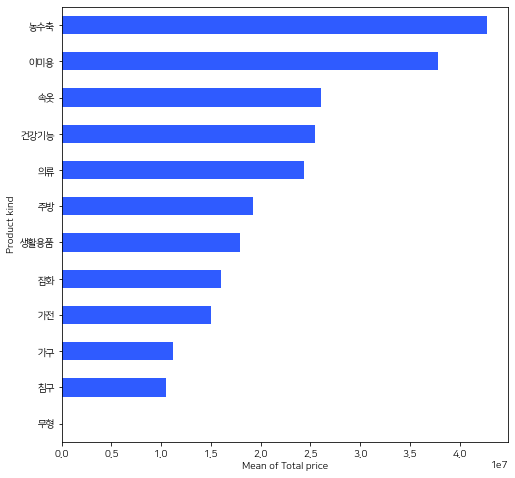

In [119]:
plt.figure(figsize=(8,8))
df.groupby('product_kind').mean()['total_price'].sort_values().plot(kind='barh',color ='#2f5bff')
plt.xlabel('Mean of Total price')
plt.ylabel('Product kind')

Text(0, 0.5, 'Product kind')

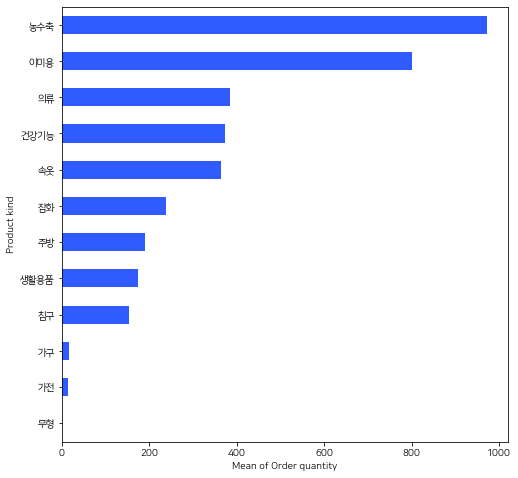

In [118]:
plt.figure(figsize=(8,8))

df.groupby('product_kind').mean()['order_quantity'].fillna(0).sort_values().plot(kind='barh',color ='#2f5bff')
plt.xlabel('Mean of Order quantity')
plt.ylabel('Product kind')

## 노출 변수 전처리

In [10]:
#노출 컬럼의 nan값을 0으로 대체
df['exposure'].fillna(0,inplace=True)

In [130]:
sub['exposure'].fillna(0,inplace=True)

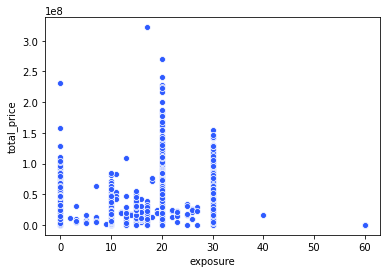

In [11]:
sns.scatterplot(x= 'exposure', y = 'total_price',data = df,color ='#2f5bff')

노출과 매출액 간 산포도. 노출을 0으로 대채할시 0인 값이 꽤많음 따라서 노출이 0 인 행들은 이전의 행이 갖고 있는 노출 값으로 입력해줌.

In [288]:
#노출이 결측치인 값을 이전 컬럼의 노출 값으로 대체

for i in range(len(df.loc[df['exposure'] == 0])):
    df.loc[df.loc[df['exposure'] == 0].iloc[0:1].index,'exposure']  = int(df.loc[df.loc[df['exposure'] == 0].iloc[0:1].index-1,'exposure'].values)

In [144]:
#sub 데이터셋도 똑같이 대체
for i in range(len(sub.loc[sub['exposure'] == 0])):
    sub.loc[sub.loc[sub['exposure'] == 0].iloc[0:1].index,'exposure']  = int(sub.loc[sub.loc[sub['exposure'] == 0].iloc[0:1].index-1,'exposure'].values)
    
    
    

In [145]:
sub.loc[sub['exposure'] == 0]

,date,exposure,mother_code,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute


노출이 0 인 값을 모두 제거해준 모습

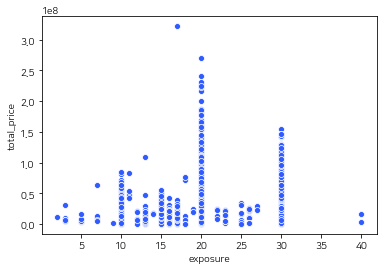

In [125]:
df = df[df['product_kind'] !='무형']
sns.scatterplot(x= 'exposure', y = 'total_price',data = df,color ='#2f5bff')

노출이 0인 값을 모두 변환해준 뒤 다시 노출과 매출액 간 산포도를 구함 노출이 20인 상품의 매출액이 높으나 대개 노출이 20인 상품이 많기 때문이라 판단됨

In [290]:
df['day_date'] = pd.to_datetime(df['date']).dt.date

In [146]:
sub['day_date'] = pd.to_datetime(sub['date']).dt.date

기존의 date 컬럼에서 시간을 제외하고 날짜만 있는 day_date 컬럼 생성

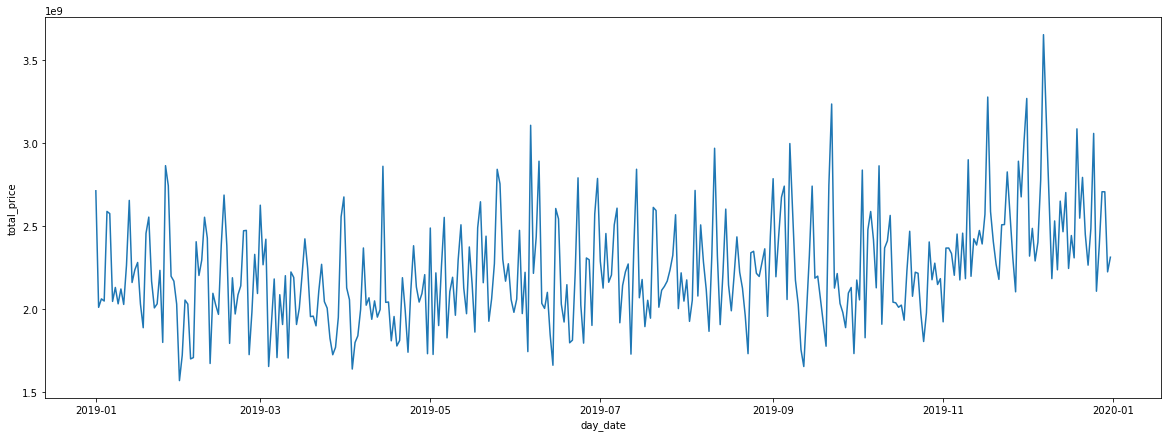

In [298]:
time_sum = df.groupby('day_date').sum().reset_index()
plt.figure(figsize=(20, 7))
sns.lineplot('day_date','total_price',data = time_sum)


만든 day_date 컬럼으로 시계열 그래프를 통해 매출액 추이 변동 확인
연말로 갈 수록 판매액이 높다

### 시청률 데이터 전처리

In [4]:
new_percent = percent.iloc[:-1,:-1]

시청률 데이터의 마지막 행과 열(합계가 표시된 행과 열임)은 제외한 새로은 데이터프레임 생성

In [5]:
new_percent = pd.melt(new_percent,id_vars='시간대',var_name = 'date',value_name='view_rate')
new_percent.head()

,시간대,date,view_rate
0,02:00,2019-01-01,0.0
1,02:01,2019-01-01,0.0
2,02:02,2019-01-01,0.0
3,02:03,2019-01-01,0.0
4,02:04,2019-01-01,0.0


melt함수를 통해 날짜별 시간대별 시청률 형태의 데이터프레임으로 변환

In [15]:
#time이라는 새로운 컬럼 생성
new_percent['time'] = None

#1분간격으로 되어있는 시간대 컬럼을 10분간격으로 묶어주기 위해 time 컬럼에 10분간격으로 시간 입력
#new_percent3 = new_percent.copy()

time_period = int(len(new_percent['시간대'])/10)
#총 길이에 10을 나눈 횟수만큼 반복
i = 0
for t in range(1,time_period):
    new_percent.iloc[i:10*t,3] = new_percent.iloc[i,0]
    i = i+10
    t = t+1

#아래 코드는 반복문 길이가 안맞아서 부득이하게 수동으로 한 라인 넣어줌
new_percent.iloc[525590:525600,3] = new_percent.iloc[525590,0]   

#time 컬럼으로 그룹바이해서 묶어줌
view_rate_df = new_percent.groupby(['date','time']).mean().reset_index()
#날짜, 시간 합쳐서 date_time이라는 컬럼 생성
view_rate_df['date_time'] = pd.to_datetime(view_rate_df['date'] + view_rate_df['time'],format = '%Y-%m-%d%H:%M')

#기존 df에 date컬럼을 datetime으로 바꾼후 15분으로 표기되있는 경우(100개정도)를 10분단위로 반올림
df['date']=pd.to_datetime(df['date'])
df['round_date']=df['date'].dt.round('10min')

#시청률데이터프레임과 기존 데이터프레임 병합

df = pd.merge(df,view_rate_df[['date_time','view_rate']],
         left_on='round_date', right_on='date_time',how='left')


기존 데이터프레임인 df와 10분단위로 묶은 시청률데이터프레임을 merge한 새로운 데이터프레임

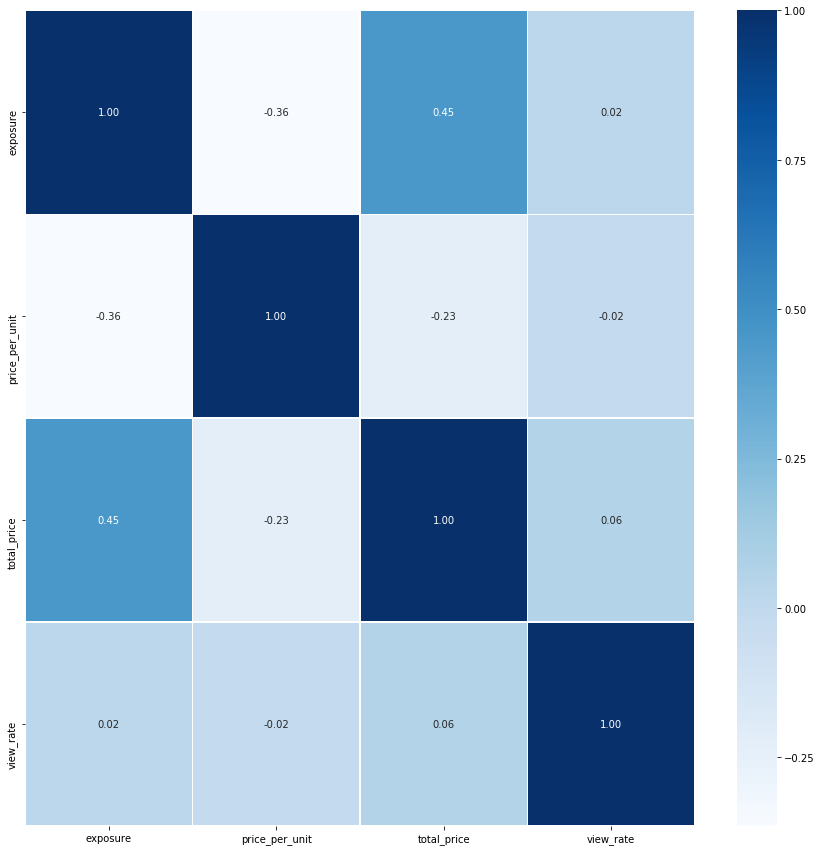

In [43]:
%matplotlib inline 
plt.figure(figsize=(15,15))
sns.heatmap(data = df_view[['exposure','price_per_unit','total_price','view_rate']].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')



데이터프레임 내 수치형변수들의 상관관계 히트맵 
노출이 상관계수가 높음
시청률은 상관관계가 적은편

# feature engineering

## 성별 변수 생성

In [83]:


# 키워드를 갖고 있는 상품명을 list로 묶음 
lists = df.loc[df['product_name'].str.contains('아동'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('브라'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('언더탑'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('코르셋'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('보정'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('쉐이'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('레깅스'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('치마'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('여자'),'product_name'].tolist()
#lists = lists + df.loc[df['product_name'].str.contains('란쥬'),'product_name'].tolist()

twitter = Twitter() 
morphs = [] 

#한글 형태소 분석기로 리스트의 상품명들을 형태소별로 분리
for sentence in lists:
    morphs.append(twitter.pos(sentence)) 
print(morphs)
noun_adj_adv_list=[] 
for sentence in morphs :
    for word, tag in sentence :
        #불필요한 워드클라우드를 제거하기 위해 특정 단어는 제외
        if tag in ['Noun'] and ("팔" not in word)and ("종" not in word): 
            noun_adj_adv_list.append(word) 
            
print(noun_adj_adv_list)






[[('디', 'Noun'), ('키즈', 'Noun'), ('아동', 'Noun'), ('스', 'Noun'), ('테디', 'Noun'), ('움', 'Noun'), ('점퍼', 'Noun'), ('세트', 'Noun')], [('디', 'Noun'), ('키즈', 'Noun'), ('아동', 'Noun'), ('스', 'Noun'), ('테디', 'Noun'), ('움', 'Noun'), ('점퍼', 'Noun'), ('세트', 'Noun')], [('디', 'Noun'), ('키즈', 'Noun'), ('아동', 'Noun'), ('스', 'Noun'), ('테디', 'Noun'), ('움', 'Noun'), ('점퍼', 'Noun'), ('세트', 'Noun')], [('디', 'Noun'), ('키즈', 'Noun'), ('아동', 'Noun'), ('스', 'Noun'), ('테디', 'Noun'), ('움', 'Noun'), ('점퍼', 'Noun'), ('세트', 'Noun')], [('디', 'Noun'), ('키즈', 'Noun'), ('아동', 'Noun'), ('스', 'Noun'), ('테디', 'Noun'), ('움', 'Noun'), ('점퍼', 'Noun'), ('세트', 'Noun')], [('디', 'Noun'), ('키즈', 'Noun'), ('아동', 'Noun'), ('스', 'Noun'), ('테디', 'Noun'), ('움', 'Noun'), ('점퍼', 'Noun'), ('세트', 'Noun')], [('USPA', 'Alpha'), ('남성', 'Noun'), ('아동', 'Noun'), ('반', 'Modifier'), ('팔', 'Noun'), ('폴로셔츠', 'Noun'), ('3', 'Number'), ('종', 'Noun')], [('USPA', 'Alpha'), ('여성', 'Noun'), ('아동', 'Noun'), ('반', 'Modifier'), ('팔', 'Noun'), ('폴로셔츠', 'Noun

In [89]:
#각 단어별 갯수를 카운트
count = Counter(noun_adj_adv_list)
words = dict(count.most_common())
words


{'아동': 59,
 '폴로셔츠': 48,
 '남성': 24,
 '여성': 24,
 '디': 9,
 '키즈': 9,
 '스': 6,
 '테디': 6,
 '움': 6,
 '점퍼': 6,
 '세트': 6,
 '리버시': 3,
 '블': 3,
 '재킷': 3,
 '스프리스': 2,
 '퍼': 2,
 '부츠': 2}

In [90]:
%matplotlib inline
#matplotlib.rc('font',family = 'Malgun Gothic')
set_matplotlib_formats('retina')
matplotlib.rc('axes',unicode_minus = False)

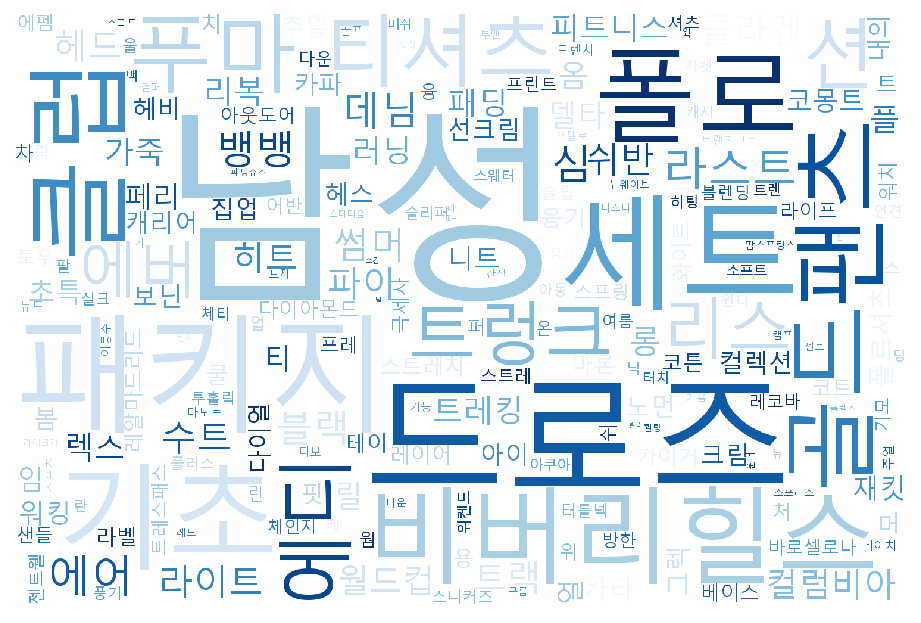

In [76]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Blues", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize=(8,8))
plt.imshow(wordcloud) 
plt.axis('off') 

plt.show()



키워드[남성, 트렁크, 드로즈] 로 추출해낸 상품명 리스트를 워드클라우드로 시각화
- 남성과 관련된 상품들로 분류가 되었음

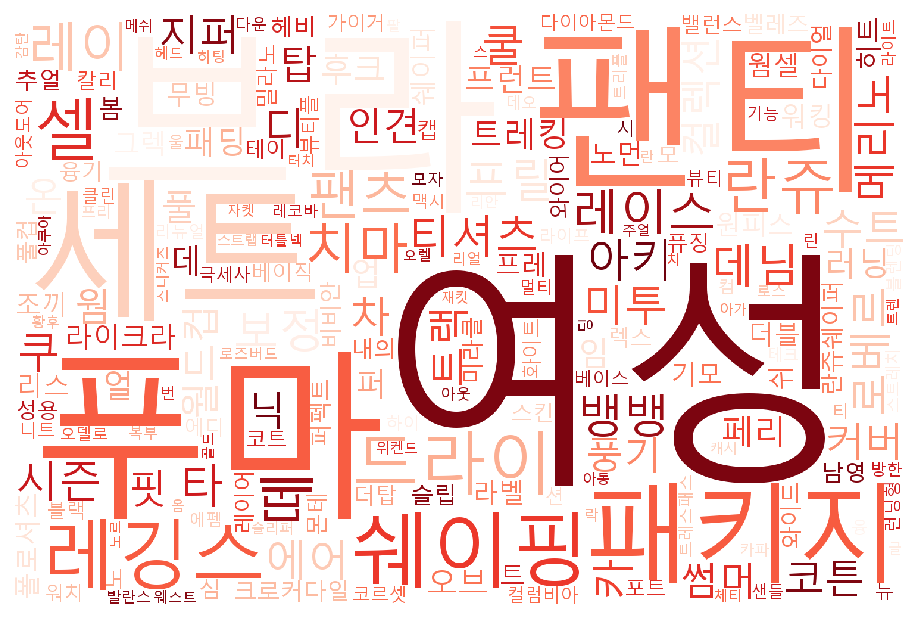

In [82]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Reds", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize=(8,8))
plt.imshow(wordcloud) 
plt.axis('off') 

plt.show()



키워드 [여성, 레깅스, 쉐이핑, 팬티, 브라 등]로 추출해낸 여성 관련 상품 분류

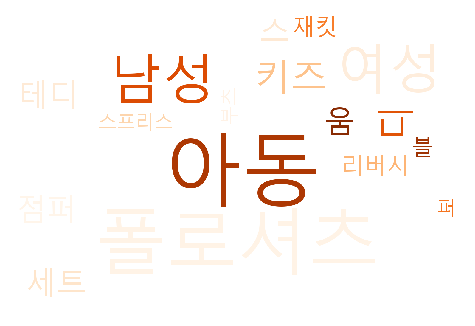

In [97]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Oranges", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize=(4,4))
plt.imshow(wordcloud) 
plt.axis('off') 

plt.show()



키워드 [아동]로 추출해낸 아동 관련 상품 분류

분류를 통한 워드클라우드 결과 각 상품군 별 성별적인 특징이 잘드러나보임.
키워드를 통해 성별별로 분류를 위한 성별변수 생성

In [291]:

df.loc[df['product_name'].str.contains('남성'),'sex'] = 'male'
df.loc[df['product_name'].str.contains('드로즈'),'sex'] = 'male'
df.loc[df['product_name'].str.contains('트렁크'),'sex'] = 'male'
df.loc[df['product_name'].str.contains('여성'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('브라'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('언더탑'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('코르셋'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('보정'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('쉐이'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('레깅스'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('치마'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('여자'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('란쥬'),'sex'] = 'female'
df.loc[df['product_name'].str.contains('아동'),'sex'] = 'child'
df['sex'].fillna('neut',inplace=True)

In [147]:
#sub 데이터프레임도 위와 동일하게 적용
sub.loc[sub['product_name'].str.contains('남성'),'sex'] = 'male'
sub.loc[sub['product_name'].str.contains('드로즈'),'sex'] = 'male'
sub.loc[sub['product_name'].str.contains('트렁크'),'sex'] = 'male'
sub.loc[sub['product_name'].str.contains('여성'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('브라'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('언더탑'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('코르셋'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('보정'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('쉐이'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('레깅스'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('치마'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('여자'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('란쥬'),'sex'] = 'female'
sub.loc[sub['product_name'].str.contains('아동'),'sex'] = 'child'
sub['sex'].fillna('neut',inplace=True)

상품이름에서 남성형 제품은 male 여성형 제품은 female 아동용 제품은 child 그외의 제품들은 중성을 의미하는 neut로 입력

## 날짜 추가 파생변수

In [295]:
#final_df = pd.read_csv('../data/bigcon/final_df.csv')
#final_df=final_df.iloc[:-9]
#final_df.drop('Unnamed: 0',axis = 1,inplace=True)

# 추가 날짜 파생변수

df['weekday_name'] = df['date'].dt.weekday
df['week_year'] = df['date'].dt.weekofyear
df['day_year'] = df['date'].dt.dayofyear
df['quarter'] = df['date'].dt.quarter

/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [148]:

#sub.drop('Unnamed: 0',axis = 1,inplace=True)
# 추가 날짜 파생변수

sub['weekday_name'] = sub['date'].dt.weekday
sub['week_year'] = sub['date'].dt.weekofyear
sub['day_year'] = sub['date'].dt.dayofyear
sub['quarter'] = sub['date'].dt.quarter

/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


요일, 주차(해당 주가 년 기준으로 몇주차인지), 일차 (해당 일이 년 기준으로 몇일인지), 분기 변수 생성

In [296]:
#월별 주차 변수
from datetime import datetime, timedelta
def get_week_no(date):
    target = date
    firstday = target.replace(day=1)
    if firstday.weekday() == 6:
        origin = firstday
    elif firstday.weekday() < 3:
        origin = firstday - timedelta(days=firstday.weekday() + 1)
    else:
        origin = firstday + timedelta(days=6-firstday.weekday())
    return (target - origin).days // 7 + 1


df['week_month'] = df.apply(lambda x: get_week_no(x['date']),axis=1)




월별로 몇주차인지 구하는 월별 주차 변수 생성

In [149]:
#월별 주차 변수
from datetime import datetime, timedelta
def get_week_no(date):
    target = date
    firstday = target.replace(day=1)
    if firstday.weekday() == 6:
        origin = firstday
    elif firstday.weekday() < 3:
        origin = firstday - timedelta(days=firstday.weekday() + 1)
    else:
        origin = firstday + timedelta(days=6-firstday.weekday())
    return (target - origin).days // 7 + 1


sub['week_month'] = sub.apply(lambda x: get_week_no(x['date']),axis=1)
sub.head()




,date,exposure,mother_code,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute,day_date,sex,weekday_name,week_year,day_year,quarter,week_month
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,06:20:00,6,20,2020-06-01,male,0,23,153,2,1
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,06:40:00,6,40,2020-06-01,male,0,23,153,2,1
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,07:00:00,7,0,2020-06-01,male,0,23,153,2,1
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,1,07:20:00,7,20,2020-06-01,female,0,23,153,2,1
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,1,07:40:00,7,40,2020-06-01,female,0,23,153,2,1


시청률 변수의 스케일을 MinMaxScaler를 통해 조정

In [80]:
#시청률 변수 스케일 조정
from sklearn.preprocessing import MinMaxScaler


sc = MinMaxScaler()
temp = sc.fit_transform(np.array(df['view_rate']).reshape(-1,1))
df['view_rate']=pd.Series(temp.reshape(1,-1)[0])


/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 마더코드 이외의 분류를 해주기 위해 ap클러스터링 사용

In [ ]:
import numpy as np
import sklearn.cluster
import distance

#상품명을 하나의 리스트에 저장한 후 각 상품명끼리의 거리를 Levenshtein distance를 이용해 계산
product_list=[]
product_list = np.append(product_list,np.asarray(df['product_name'].unique()))
words = product_list 
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])

#각 상품명끼리의 거리를 통해 근접한 상품들끼리 군집 진행
#즉 상품명끼리의 거리가 좁다면 같은 클러스터로 군집화가 진행됨
affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping=0.7,preference=-30,verbose=True)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

In [144]:
#분류된 클러스터를 product_cluster라는 변수로 새로운 컬럼생성
for cluster_id in np.unique(affprop.labels_):
    df.loc[df['product_name'].isin(np.unique(words[np.nonzero(affprop.labels_==cluster_id)])),'product_cluster'] = cluster_id

In [195]:
for cluster_id in np.unique(affprop.labels_):
    sub.loc[sub['product_name'].isin(np.unique(words[np.nonzero(affprop.labels_==cluster_id)])),'product_cluster'] = cluster_id

Text(0.5, 1.0, '마더코드별 데이터 개수_로베르타 디 까메리노')

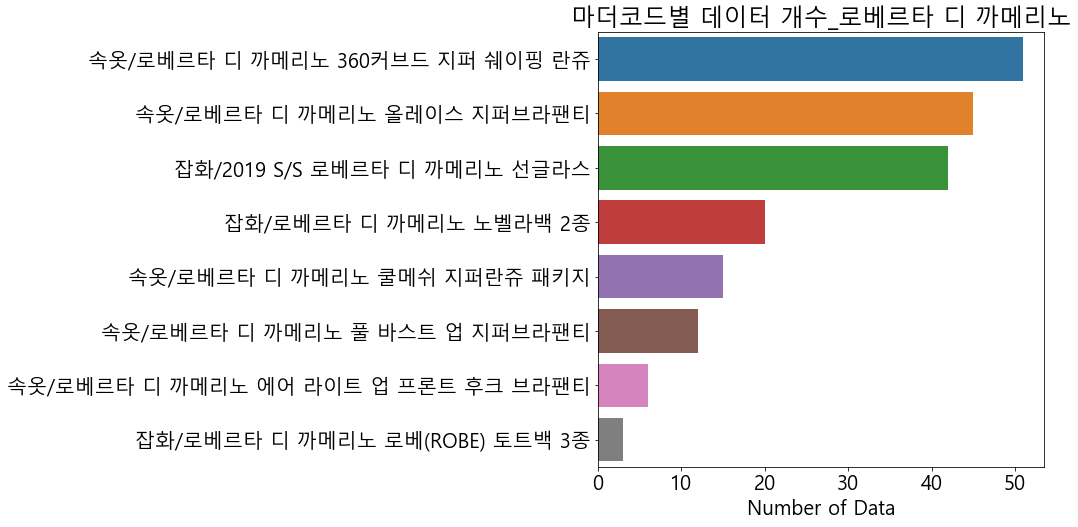

In [19]:
lable_name = {}
for i in roberta['mother_code'].value_counts().index.tolist():
    pro_list = roberta.loc[roberta['mother_code'] == i,['product_kind','product_name']].iloc[0].tolist()
    text = "/".join(pro_list)
    lable_name[i] = text

roberta = df[df['product_cluster'] == 1]
roberta_value = roberta['mother_code'].value_counts()
roberta_df = pd.DataFrame(roberta_value).reset_index()
roberta_df['new_index'] = lable_name.values()

#fm.get_fontconfig_fonts()
#font_location = '/Library/Fonts/GothicBold.ttf'
#font_name = fm.FontProperties(fname=font_location).get_name()
#plt.rc('font', family=font_name)
plt.figure(figsize=(8,8))
plt.rc('font', size = 20)
sns.barplot(x='mother_code',y='new_index',data=roberta_df)
plt.xlabel('Number of Data')
plt.ylabel('')
plt.title('마더코드별 데이터 개수_로베르타 디 까메리노')

같은 브랜드 클러스터에 속하지만 각기 다른 마더코드를 갖고있는 상품들의 갯수 시각화

상품이름별로 거리를 구하여 클러스터링함 결과적으로 같은 브랜드이름을 가진 상품끼리 묶이는 클러스터가 생성됨. 하지만 브랜드가 없거나 해당 브랜드의 판매제품이 적은경우 제대로 클러스터링이 되지는 않음 위 변수를 brand 변수로 사용

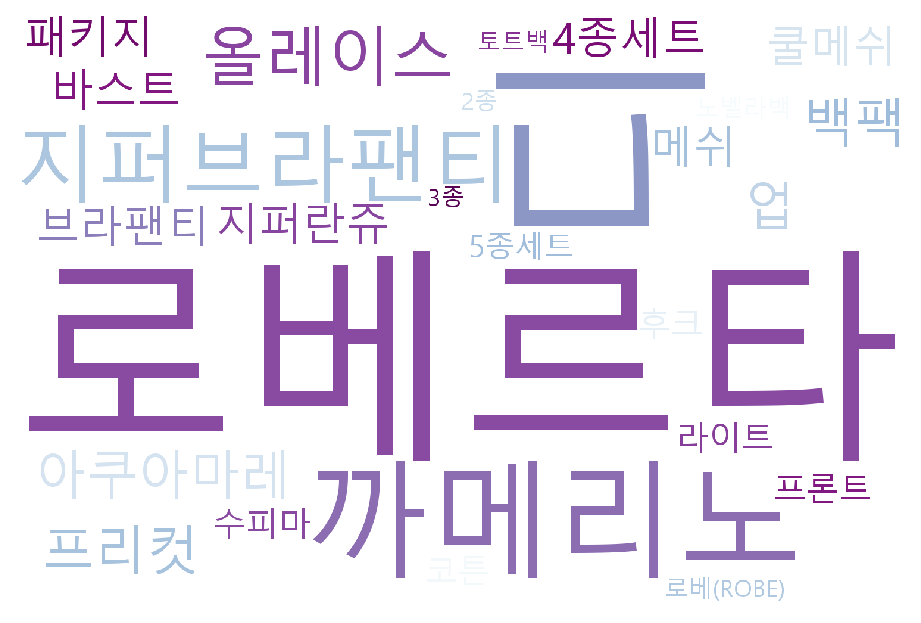

In [155]:
from konlpy.tag import Hannanum
from collections import Counter

lists = df.loc[df['product_cluster']==3,'product_name'].tolist()

han = Hannanum()
twitter = Twitter() 
morphs = [] 
for sentence in lists:
    morphs.append(han.pos(sentence)) 

noun_adj_adv_list=[] 
for sentence in morphs :
    for word, tag in sentence :
        if tag in ['N']: #and ("팔" not in word)and ("종" not in word): 
            noun_adj_adv_list.append(word) 
            


count = Counter(noun_adj_adv_list)
words = dict(count.most_common())
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "BuPu", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize=(8,8))
plt.imshow(wordcloud) 
plt.axis('off') 

plt.show()



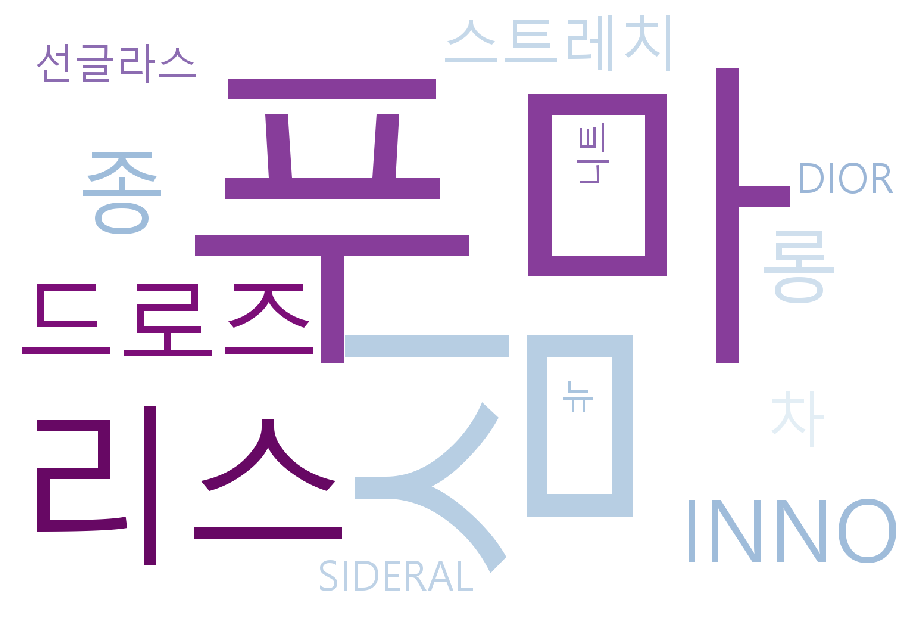

In [176]:
from konlpy.tag import Hannanum
from collections import Counter

lists = df.loc[df['product_cluster']==9,'product_name'].tolist()

#han = Hannanum()
twitter = Twitter() 
morphs = [] 
for sentence in lists:
    morphs.append(twitter.pos(sentence)) 

noun_adj_adv_list=[] 
for sentence in morphs :
    for word, tag in sentence :
        if tag in ['Noun'] or tag in ['Alpha']: #and ("팔" not in word)and ("종" not in word): 
            noun_adj_adv_list.append(word) 
            


count = Counter(noun_adj_adv_list)
words = dict(count.most_common())

wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "BuPu", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize=(8,8))
plt.imshow(wordcloud) 
plt.axis('off') 

plt.show()



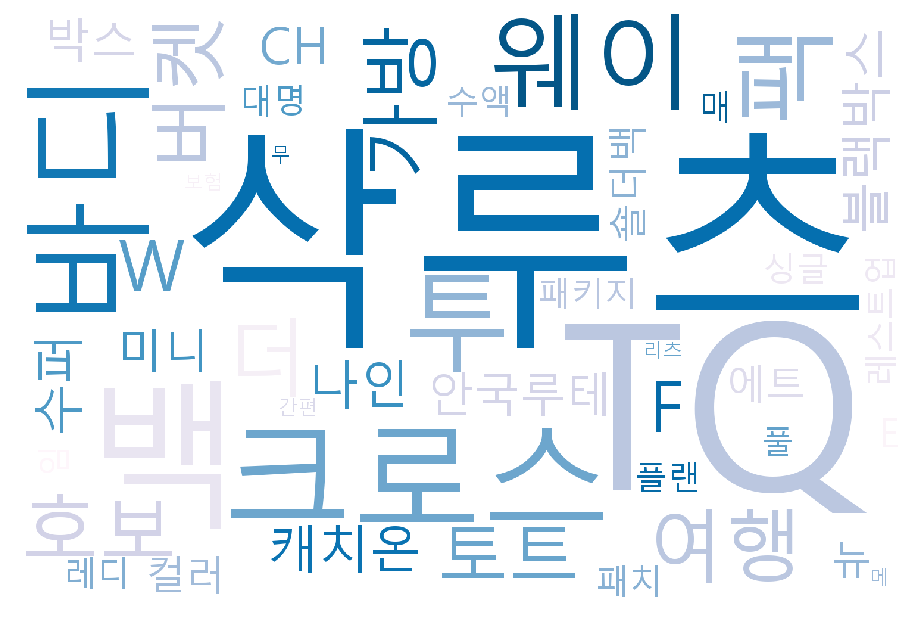

In [206]:
from konlpy.tag import Hannanum
from collections import Counter

lists = df.loc[df['product_cluster']==40,'product_name'].tolist()

#han = Hannanum()
twitter = Twitter() 
morphs = [] 
for sentence in lists:
    morphs.append(twitter.pos(sentence)) 

noun_adj_adv_list=[] 
for sentence in morphs :
    for word, tag in sentence :
        if tag in ['Noun'] or tag in ['Alpha']: #and ("팔" not in word)and ("종" not in word): 
            noun_adj_adv_list.append(word) 
            


count = Counter(noun_adj_adv_list)
words = dict(count.most_common())

wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "PuBu", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize=(8,8))
plt.imshow(wordcloud) 
plt.axis('off') 

plt.show()



같은 브랜드끼리 잘 묶였는지 시각화  
로베르타 디 까메리노, 푸마, 삭루츠 등의 브랜드로 묶인것이 눈에 띈다

---

# 외부데이터

In [33]:
#final_df = pd.read_csv('../data/bigcon/final_df_0813.csv')

In [4]:
life_price = pd.read_csv('../data/bigcon/생활물가지수.csv',encoding='CP949')
life_price

,시도별,품목별,2019. 01,2019. 02,2019. 03,2019. 04,2019. 05,2019. 06,2019. 07,2019. 08,...,2019. 10,2019. 11,2019. 12,2020. 01,2020. 02,2020. 03,2020. 04,2020. 05,2020. 06,2020. 07
0,전국,총지수,104.24,104.69,104.49,104.87,105.05,104.88,104.56,104.81,...,105.46,104.87,105.12,105.79,105.80,105.54,104.95,104.71,104.87,104.86
1,전국,생활물가지수,104.03,104.61,104.45,104.81,105.29,105.19,104.40,104.73,...,105.96,105.37,105.51,106.26,106.39,106.31,105.11,104.55,104.88,104.39
2,전국,식품,108.79,109.33,108.76,109.29,109.18,108.76,108.38,109.25,...,111.20,109.50,109.59,110.72,110.60,111.39,111.00,111.34,111.33,111.43
3,전국,식품 이외,101.49,102.09,102.16,102.43,103.22,103.30,102.29,102.32,...,103.16,103.17,103.36,103.89,104.16,103.59,101.97,100.94,101.45,100.64
4,전국,전월세,104.19,104.18,104.14,104.10,104.07,104.00,103.98,103.95,...,103.96,103.97,103.99,104.03,104.06,104.08,104.11,104.14,104.17,104.23
5,전국,생활물가 이외,104.53,104.91,104.58,105.10,104.93,104.62,104.89,105.09,...,105.08,104.35,104.79,105.50,105.34,104.77,104.89,105.05,104.98,105.63
6,전국,전·월세포함 생활물가지수,104.05,104.55,104.40,104.70,105.10,105.01,104.34,104.61,...,105.65,105.15,105.29,105.93,106.04,105.97,104.96,104.49,104.77,104.36


외부데이터인 생활 물가지수 데이터를 불러온다

In [56]:

life_price_melt = pd.melt(life_price.drop('시도별',axis=1),id_vars=['품목별'],var_name = 'date',value_name='price')

life_price_df =life_price_melt[life_price_melt['품목별'] == '생활물가지수']
food_price_df = life_price_melt[life_price_melt['품목별'] == '식품']
non_food_df = life_price_melt[life_price_melt['품목별'] == '식품 이외']


In [63]:
temp = pd.merge(food_price_df,life_price_df[['date','price']],on='date')
price_trend = pd.merge(temp, non_food_df, on = 'date')
price_trend = price_trend.rename({'price_x':'food_price','price_y':'life_price',
                   'price':'non_food_price'},axis='columns')[['date','food_price','life_price','non_food_price']]
price_trend


,date,food_price,life_price,non_food_price
0,2019. 01,108.79,104.03,101.49
1,2019. 02,109.33,104.61,102.09
2,2019. 03,108.76,104.45,102.16
3,2019. 04,109.29,104.81,102.43
4,2019. 05,109.18,105.29,103.22
5,2019. 06,108.76,105.19,103.30
6,2019. 07,108.38,104.40,102.29
7,2019. 08,109.25,104.73,102.32
8,2019. 09,110.69,105.57,102.84
9,2019. 10,111.20,105.96,103.16


melt 함수를 이용한 뒤 생활물가지수, 식품물가지수, 식품 이외 물가지수 세 지표를 변수로 사용

In [304]:
price_trend = pd.read_csv('../data/bigcon/price_trend.csv')
price_trend.drop('Unnamed: 0',axis=1,inplace=True)

In [317]:
df['temp_date'] = df['day_date'].astype('str').str[:-3].str.replace('-','. ')
df=pd.merge(df,price_trend,left_on='temp_date',right_on = 'date').drop('temp_date',axis=1)
#sub_final['temp_date'] = sub_final['day_date'].astype('str').str[:-3].str.replace('-','. ')
#sub_final=pd.merge(sub_final,price_trend,left_on='temp_date',right_on = 'date').drop('temp_date',axis=1)

In [68]:
price_trend.to_csv('../data/bigcon/price_trend.csv')

In [157]:
sub['temp_date'] = sub['day_date'].astype('str').str[:-3].str.replace('-','. ')
sub=pd.merge(sub,price_trend,left_on='temp_date',right_on = 'date')
sub_life

,date_x,exposure,mother_code,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute,sex,round_date,view_rate,day_date,weekday_name,week_year,day_year,quarter,week_month,date,food_price,life_price,non_food_price
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,06:20:00,6,20,male,2020-06-01 06:20:00,0.001807,2020-06-01,0,23,153,2,1,2020. 06,111.33,104.88,101.45
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,06:40:00,6,40,female,2020-06-01 06:40:00,0.001793,2020-06-01,0,23,153,2,1,2020. 06,111.33,104.88,101.45
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,07:00:00,7,0,male,2020-06-01 07:00:00,0.001802,2020-06-01,0,23,153,2,1,2020. 06,111.33,104.88,101.45
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,1,07:20:00,7,20,female,2020-06-01 07:20:00,0.001828,2020-06-01,0,23,153,2,1,2020. 06,111.33,104.88,101.45
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,1,07:40:00,7,40,male,2020-06-01 07:40:00,0.001827,2020-06-01,0,23,153,2,1,2020. 06,111.33,104.88,101.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,2020,7,1,00:20:00,0,20,neut,2020-07-01 00:20:00,0.001851,2020-07-01,2,27,183,3,1,2020. 07,111.43,104.39,100.64
2887,2020-07-01 00:40:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,2020,7,1,00:40:00,0,40,neut,2020-07-01 00:40:00,0.001793,2020-07-01,2,27,183,3,1,2020. 07,111.43,104.39,100.64
2888,2020-07-01 01:00:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,2020,7,1,01:00:00,1,0,female,2020-07-01 01:00:00,0.001775,2020-07-01,2,27,183,3,1,2020. 07,111.43,104.39,100.64
2889,2020-07-01 01:20:00,20.0,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,2020,7,1,01:20:00,1,20,male,2020-07-01 01:20:00,0.001786,2020-07-01,2,27,183,3,1,2020. 07,111.43,104.39,100.64


물가지수데이터를 기존 데이터프레임과 병합

---

# 기온 외부 변수 생성

In [310]:
temperture = pd.read_csv('../data/bigcon/1901-2001.csv',encoding='CP949')


외부 데이터인 기온 변수인 기온, 강수량, 풍속, 습도, 기압, 일조, 일사, 적설, 가시거리 사용

In [311]:
temp_date =temperture.groupby('일시').mean().reset_index()

In [312]:
temp_date.columns = ['date','point','tempeture','rain','wind_speed','humidity','atmospheric_pressure','sunlight','solar_radiation','snow','sight','ground']
temp_date.head()

,date,point,tempeture,rain,wind_speed,humidity,atmospheric_pressure,sunlight,solar_radiation,snow,sight,ground
0,2019-01-01 01:00,196.673684,-3.862105,NaN,1.741053,54.263158,1020.658947,NaN,NaN,6.9,1866.836957,NaN
1,2019-01-01 02:00,196.673684,-4.122105,NaN,1.722105,56.768421,1020.608421,NaN,NaN,6.9,1852.467391,NaN
2,2019-01-01 03:00,196.673684,-4.240000,NaN,1.754737,58.421053,1020.755789,NaN,NaN,7.1,1809.064516,NaN
3,2019-01-01 04:00,196.673684,-4.387368,NaN,1.746316,60.273684,1020.396842,NaN,NaN,6.9,1823.236559,NaN
4,2019-01-01 05:00,196.673684,-4.354737,NaN,1.980000,61.621053,1019.853684,NaN,NaN,6.9,1804.397849,NaN


기온 데이터프레임의 컬럼이름을 전부 영어로 변환해주고 날짜별로 그룹바이해줌

In [313]:
temp_date.drop(['point','ground'],axis=1,inplace=True)
temp_date.fillna(0,inplace=True)

NaN 값을 모두 0으로 바꾸고 쓰지 않는 컬럼은 삭제

In [315]:
df['temp_date']=df['round_date'].astype('str').str[:-5] + '00'

In [316]:
pd.set_option('display.max_columns', 100)
df = pd.merge(df,temp_date,left_on='temp_date',right_on='date',how='left')
#final_df_temp.drop(['temp_date','date_y'],axis=1,inplace=True)
df

,date_x,exposure,mother_code,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute,day_date,sex,order_quantity,weekday_name,week_year,day_year,quarter,week_month,round_date,product_cluster,date_y,food_price,life_price,non_food_price,price_per_exposure,temp_date,date,tempeture,rain,wind_speed,humidity,atmospheric_pressure,sunlight,solar_radiation,snow,sight
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019,1,1,06:00:00,6,0,2019-01-01,male,53.0,1,1,1,1,1,2019-01-01 06:00:00,25.0,2019. 01,108.79,104.03,101.49,2.099e+06,2019-01-01 06:00,2019-01-01 06:00,-4.409474,0.0,2.046316,63.147368,1019.831579,0.0,0.0,7.1,1831.956989
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019,1,1,06:00:00,6,0,2019-01-01,female,110.0,1,1,1,1,1,2019-01-01 06:00:00,25.0,2019. 01,108.79,104.03,101.49,4.371e+06,2019-01-01 06:00,2019-01-01 06:00,-4.409474,0.0,2.046316,63.147368,1019.831579,0.0,0.0,7.1,1831.956989
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019,1,1,06:20:00,6,20,2019-01-01,male,82.0,1,1,1,1,1,2019-01-01 06:20:00,25.0,2019. 01,108.79,104.03,101.49,1.163e+06,2019-01-01 06:00,2019-01-01 06:00,-4.409474,0.0,2.046316,63.147368,1019.831579,0.0,0.0,7.1,1831.956989
3,2019-01-01 06:20:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019,1,1,06:20:00,6,20,2019-01-01,female,174.0,1,1,1,1,1,2019-01-01 06:20:00,25.0,2019. 01,108.79,104.03,101.49,2.584e+06,2019-01-01 06:00,2019-01-01 06:00,-4.409474,0.0,2.046316,63.147368,1019.831579,0.0,0.0,7.1,1831.956989
4,2019-01-01 06:40:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019,1,1,06:40:00,6,40,2019-01-01,male,167.0,1,1,1,1,1,2019-01-01 06:40:00,25.0,2019. 01,108.79,104.03,101.49,3.41e+06,2019-01-01 06:00,2019-01-01 06:00,-4.409474,0.0,2.046316,63.147368,1019.831579,0.0,0.0,7.1,1831.956989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0.0,2020,1,1,00:20:00,0,20,2020-01-01,neut,NaN,2,1,1,1,1,2020-01-01 00:20:00,21.0,2020. 01,110.72,106.26,103.89,0,2020-01-01 00:00,2020-01-01 00:00,-5.260000,0.0,2.142553,52.431579,1019.833333,0.0,0.0,10.0,2261.095745
38305,2020-01-01 00:40:00,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0.0,2020,1,1,00:40:00,0,40,2020-01-01,neut,NaN,2,1,1,1,1,2020-01-01 00:40:00,21.0,2020. 01,110.72,106.26,103.89,0,2020-01-01 00:00,2020-01-01 00:00,-5.260000,0.0,2.142553,52.431579,1019.833333,0.0,0.0,10.0,2261.095745
38306,2020-01-01 01:00:00,20,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0.0,2020,1,1,01:00:00,1,0,2020-01-01,neut,NaN,2,1,1,1,1,2020-01-01 01:00:00,21.0,2020. 01,110.72,106.26,103.89,0,2020-01-01 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38307,2020-01-01 01:20:00,20,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,0.0,2020,1,1,01:20:00,1,20,2020-01-01,neut,NaN,2,1,1,1,1,2020-01-01 01:20:00,88.0,2020. 01,110.72,106.26,103.89,0,2020-01-01 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
sub['temp_date']=sub['round_date'].astype('str').str[:-5] + '00'
sub = pd.merge(sub,temp_date,left_on='temp_date',right_on='date',how='left')
#sub.drop(['temp_date','date'],axis=1,inplace=True)

기존 데이터프레임과 기온 데이터프레임을 병합해줌

# 노출당 가격 계산

매출액이 해당 노출당 잘라있는게 아닌 통으로 합쳐있어서 건당으로 빼줌

In [308]:
df['price_per_exposure'] = None
product_list = df['product_name'].unique()
for product in product_list:

    day_date = df.loc[(df['product_name'] == product),'day_date'].unique()
    for day in day_date:
        df_index = df.loc[(df['product_name'] == product) & (df['day_date'] == day)].index.tolist()
        length = len(df_index)
        for i in range(length-1,-1,-1):
            if i == 0:
                temp_num = df.loc[df_index,'total_price'].iloc[i]
                df.loc[df_index[i],'price_per_exposure']= temp_num
            else :

                temp_num = df.loc[df_index,'total_price'].iloc[i] - df.loc[df_index,'total_price'].iloc[i-1]
                df.loc[df_index[i],'price_per_exposure'] = temp_num



# 자기상관 확인

In [165]:
df['price_time_lag_1'] = None
df['price_diff_1'] = None
product_list = df['product_name'].unique()
for product in product_list:

    df_index = df.loc[(df['product_name'] == product)].index.tolist()
    length = len(df_index)
    for i in range(1,length):
        temp_num = df.loc[df_index[i],'price_per_exposure'] - df.loc[df_index[i-1],'price_per_exposure']
        df.loc[df_index[i],'price_diff_1'] = temp_num
        df.loc[df_index[i],'price_time_lag_1'] = df.loc[df_index[i-1],'price_per_exposure']

In [177]:
df_lag = df[~df['price_time_lag_1'].isnull()]
df_lag[['price_per_exposure','price_time_lag_1','price_diff_1']] = df_lag[['price_per_exposure','price_time_lag_1','price_diff_1']].astype('float')

In [190]:
data_corr = df_lag[['exposure', 'price_per_unit', 'order_quantity', 'view_rate','tempeture','rain','wind_speed',
        'humidity','atmospheric_pressure','sunlight','solar_radiation','snow','food_price','life_price',
        'non_food_price','sight','total_price','price_per_exposure','price_time_lag_1','price_diff_1']]

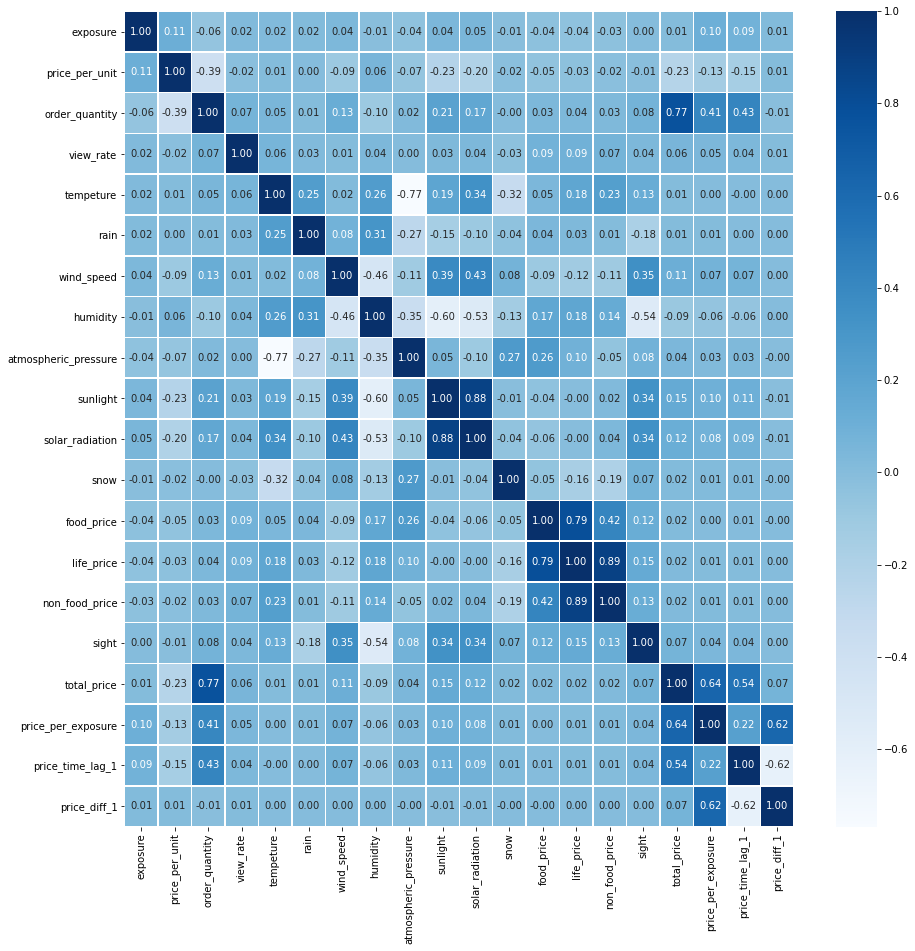

In [189]:
%matplotlib inline 
plt.figure(figsize=(15,15))
sns.heatmap(data = data_corr.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')


시차 및 변수를 차분한 결과 시계열적인 특징을 찾기 힘듬. 상품이 마더코드로 같다고는 하지만 실제적으로는 다른 상품이기 때문에 판매단가도 달라서 시계열외의 변수가 많음

In [333]:
#df.drop(['date_y','date_x','food_price_y', 'life_price_y', 'non_food_price_y'],axis=1,inplace=True)


In [341]:
#df.rename({'food_price_x':'food_price','life_price_x':'life_price', 'non_food_price_x':'non_food_price'},axis=1,inplace=True)

In [342]:
df.to_csv('../data/bigcon/bigcon_before_master.csv',index=False)

---
# 마스터테이블 제작

### 사전 EDA

주문량 평균은 음식류들이 순위에 오름

eda결과 마더코드별 매출의 평균은 다양한 상품군이 랭크에 오름. 하지만 마더코드별 주문량 평균은 음식류들이 랭크에 차지 해당

In [10]:
#통계치를 구하기 위해 숫자형으로 데이터형변환
df[['exposure','price_per_exposure']] = df[['exposure','price_per_exposure']].astype('float')

In [350]:
#마더코드별 노출, 매출액, 주문량, 판매단가, 노출당 가격, 시청률 기술통계치 계산
final_df_temp = df
mother_sum=final_df_temp.groupby('mother_code').sum()[['exposure','total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
mother_mean=final_df_temp.groupby('mother_code').mean()[['exposure','total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
mother_median = final_df_temp.groupby('mother_code').median()[['exposure','total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
mother_count = final_df_temp.groupby('mother_code').count()[['total_price']].reset_index()
mother_std = final_df_temp.groupby('mother_code').std()[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
mother_25=final_df_temp.groupby('mother_code').quantile(q=0.25)[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
mother_75=final_df_temp.groupby('mother_code').quantile(q=0.75)[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
mother_min = final_df_temp.groupby('mother_code').min()[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
mother_max = final_df_temp.groupby('mother_code').max()[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()





In [352]:
mother_sum.columns = ['mother_code','mother_exp_sum','mother_total_sum','mother_order_sum','mother_unit_sum','mother_ppe_sum','mother_view_sum']
mother_mean.columns = ['mother_code','mother_exp_mean','mother_total_mean','mother_order_mean','mother_unit_mean','mother_ppe_mean','mother_view_mean']
mother_median.columns = ['mother_code','mother_exp_median','mother_total_median','mother_order_median','mother_unit_median','mother_ppe_median','mother_view_median']
mother_count.columns = ['mother_code','mother_count']
mother_std.columns = ['mother_code','mother_total_std','mother_order_std','mother_unit_std','mother_ppe_std','mother_view_std']
mother_25.columns = ['mother_code','mother_total_25','mother_order_25','mother_unit_25','mother_ppe_25','mother_view_25']
mother_75.columns = ['mother_code','mother_total_75','mother_order_75','mother_unit_75','mother_ppe_75','mother_view_75']
mother_max.columns = ['mother_code','mother_total_max','mother_order_max','mother_unit_max','mother_ppe_max','mother_view_max']
mother_min.columns = ['mother_code','mother_total_min','mother_order_min','mother_unit_min','mother_ppe_min','mother_view_min']

mother=[mother_sum, mother_mean.iloc[:,1:],mother_median.iloc[:,1:],mother_count.iloc[:,1:],
mother_std.iloc[:,1:],mother_25.iloc[:,1:],mother_75.iloc[:,1:],
mother_max.iloc[:,1:],mother_min.iloc[:,1:]]
mother_master = pd.concat(mother, axis=1)


In [354]:
mother_master.head()

,mother_code,mother_exp_sum,mother_total_sum,mother_order_sum,mother_unit_sum,mother_ppe_sum,mother_view_sum,mother_exp_mean,mother_total_mean,mother_order_mean,mother_unit_mean,mother_ppe_mean,mother_view_mean,mother_exp_median,mother_total_median,mother_order_median,mother_unit_median,mother_ppe_median,mother_view_median,mother_count,mother_total_std,mother_order_std,mother_unit_std,mother_ppe_std,mother_view_std,mother_total_25,mother_order_25,mother_unit_25,mother_ppe_25,mother_view_25,mother_total_75,mother_order_75,mother_unit_75,mother_ppe_75,mother_view_75,mother_total_max,mother_order_max,mother_unit_max,mother_ppe_max,mother_view_max,mother_total_min,mother_order_min,mother_unit_min,mother_ppe_min,mother_view_min
0,100000,115.0,76562000.0,959.0,479400,29353000.0,0.0298,19.166667,1.276033e+07,159.833333,79900.0,4.892167e+06,0.004967,20.0,11983000.0,150.0,79900.0,5582500.0,0.00220,6,4.500672e+06,56.339743,0.0,4.513947e+06,0.007633,11340500.0,142.25,79900.0,1957750.0,0.000425,16023000.0,200.50,79900.0,5963500.0,0.004725,18195000.0,228.0,79900,12078000.0,0.0200,5905000.0,74.0,79900,-730000.0,0.0
1,100001,120.0,151336000.0,1529.0,396000,95841000.0,0.0215,30.000000,3.783400e+07,382.250000,99000.0,2.396025e+07,0.005375,30.0,38607500.0,390.0,99000.0,21498500.0,0.00275,4,1.340605e+07,135.391716,0.0,6.973622e+06,0.007543,30982750.0,313.25,99000.0,20614250.0,0.000000,45458750.0,459.00,99000.0,24844500.0,0.008125,52844000.0,534.0,99000,34218000.0,0.0160,21277000.0,215.0,99000,18626000.0,0.0
2,100002,300.0,571247000.0,11448.0,748500,242111000.0,0.1708,20.000000,3.808313e+07,763.200000,49900.0,1.614073e+07,0.011387,20.0,36441000.0,730.0,49900.0,11660000.0,0.00880,15,9.665085e+06,193.552946,0.0,8.897093e+06,0.011176,32748500.0,656.50,49900.0,10019500.0,0.001450,45424500.0,910.00,49900.0,22667000.0,0.018850,52443000.0,1051.0,49900,34069000.0,0.0317,21834000.0,438.0,49900,8207000.0,0.0
3,100006,440.0,444941000.0,8935.0,2191200,140018000.0,0.1748,10.000000,1.011230e+07,203.068182,49800.0,3.182227e+06,0.003973,10.0,8931500.0,179.5,49800.0,2579000.0,0.00185,44,5.082599e+06,101.976148,0.0,3.950539e+06,0.005831,6711500.0,135.00,49800.0,961500.0,0.000000,13039500.0,262.25,49800.0,5089750.0,0.006200,24420000.0,490.0,49800,14064000.0,0.0216,1603000.0,32.0,49800,-6284000.0,0.0
4,100009,60.0,92222000.0,2312.0,119700,35700000.0,0.0054,20.000000,3.074067e+07,770.666667,39900.0,1.190000e+07,0.001800,20.0,32271000.0,809.0,39900.0,8020000.0,0.00000,3,5.875912e+06,147.289963,0.0,1.093982e+07,0.003118,28261000.0,708.50,39900.0,5724500.0,0.000000,33985500.0,852.00,39900.0,16135500.0,0.002700,35700000.0,895.0,39900,24251000.0,0.0054,24251000.0,608.0,39900,3429000.0,0.0


### 마더코드별 마스터테이블 생성

In [11]:
#mother_master.to_csv('../data/bigcon/mother_master.csv',index=False)
mother_master = pd.read_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/mother_master.csv')


In [12]:
final_df_temp = df

In [356]:
product_sum=final_df_temp.groupby('product_kind').sum()[['exposure','total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
product_mean=final_df_temp.groupby('product_kind').mean()[['exposure','total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
product_median = final_df_temp.groupby('product_kind').median()[['exposure','total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
product_count = final_df_temp.groupby('product_kind').count()[['total_price']].reset_index()
product_std = final_df_temp.groupby('product_kind').std()[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
product_25=final_df_temp.groupby('product_kind').quantile(q=0.25)[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
product_75=final_df_temp.groupby('product_kind').quantile(q=0.75)[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
product_min = final_df_temp.groupby('product_kind').min()[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()
product_max = final_df_temp.groupby('product_kind').max()[['total_price','order_quantity','price_per_unit','price_per_exposure','view_rate']].reset_index()


product_sum.columns = ['product_name','product_exp_sum','product_total_sum','product_order_sum','product_unit_sum','product_ppe_sum','product_view_sum']
product_mean.columns = ['product','product_exp_mean','product_total_mean','product_order_mean','product_unit_mean','product_ppe_mean','product_view_mean']
product_median.columns = ['product','product_exp_median','product_total_median','product_order_median','product_unit_median','product_ppe_median','product_view_median']
product_count.columns = ['producte','product_count']
product_std.columns = ['product','product_total_std','product_order_std','product_unit_std','product_ppe_std','product_view_std']
product_25.columns = ['product','product_total_25','product_order_25','product_unit_25','product_ppe_25','product_view_25']
product_75.columns = ['product','product_total_75','product_order_75','product_unit_75','product_ppe_75','product_view_75']
product_max.columns = ['product','product_total_max','product_order_max','product_unit_max','product_ppe_max','product_view_max']
product_min.columns = ['product','product_total_min','product_order_min','product_unit_min','product_ppe_min','product_view_min']



In [357]:
product=[product_sum, product_mean.iloc[:,1:],product_median.iloc[:,1:],product_count.iloc[:,1:],
product_std.iloc[:,1:],product_25.iloc[:,1:],product_75.iloc[:,1:],
product_max.iloc[:,1:],product_min.iloc[:,1:]]
product_master = pd.concat(product, axis=1)
product_master


,product_name,product_exp_sum,product_total_sum,product_order_sum,product_unit_sum,product_ppe_sum,product_view_sum,product_exp_mean,product_total_mean,product_order_mean,product_unit_mean,product_ppe_mean,product_view_mean,product_exp_median,product_total_median,product_order_median,product_unit_median,product_ppe_median,product_view_median,product_count,product_total_std,product_order_std,product_unit_std,product_ppe_std,product_view_std,product_total_25,product_order_25,product_unit_25,product_ppe_25,product_view_25,product_total_75,product_order_75,product_unit_75,product_ppe_75,product_view_75,product_total_max,product_order_max,product_unit_max,product_ppe_max,product_view_max,product_total_min,product_order_min,product_unit_min,product_ppe_min,product_view_min
0,가구,52968.0,2.913114e+10,45478.0,2204847000,1.620553e+10,10.5811,20.263198,1.114428e+07,17.397858,8.434763e+05,6.199513e+06,0.004048,20.0,7372000.0,10.0,648000,4538500.0,0.0000,2614,1.106224e+07,20.405178,516310.428154,7.648285e+06,0.007960,3087000.0,3.0,598000.0,1402000.0,0.0,16219750.0,25.00,949000.0,9825750.0,0.003800,72449000.0,232.0,3990000,47185000.0,0.0494,0.0,0.0,89000,-25284000.0,0.0
1,가전,130740.0,9.706092e+10,100073.0,10569727000,4.790587e+10,23.8415,20.179040,1.498085e+07,15.445748,1.631382e+06,7.394022e+06,0.003680,20.0,9432000.0,6.0,1499000,5417000.0,0.0000,6479,1.740403e+07,25.786477,788349.139394,1.236246e+07,0.007405,3300000.0,2.0,1080000.0,0.0,0.0,20993500.0,18.00,2209000.0,12418500.0,0.004000,231789000.0,340.0,3190000,223485000.0,0.0816,0.0,0.0,164000,-74693000.0,0.0
2,건강기능,15937.0,2.010362e+10,294472.0,65826200,7.772442e+09,2.5987,20.173418,2.544762e+07,372.749367,8.332430e+04,9.838534e+06,0.003289,20.0,22828000.0,313.0,75050,8514500.0,0.0000,790,1.720206e+07,299.609726,39043.847883,1.221307e+07,0.007957,12603750.0,142.0,59900.0,3755500.0,0.0,35034500.0,561.75,79000.0,15575000.0,0.003000,216065000.0,3607.0,238000,171971000.0,0.0629,0.0,0.0,39900,-56876000.0,0.0
3,농수축,76046.0,1.659422e+11,3776027.0,180293500,6.883059e+10,22.3137,19.579300,4.272457e+07,972.200566,4.641954e+04,1.772157e+07,0.005745,20.0,40595000.0,870.0,43900,15918500.0,0.0015,3884,2.094726e+07,524.478279,12736.003935,1.726523e+07,0.009700,28878500.0,615.0,36900.0,7238250.0,0.0,53642500.0,1255.00,55900.0,26902250.0,0.007700,270284000.0,6458.0,109900,270284000.0,0.1048,1292000.0,35.0,28900,-222781000.0,0.0
4,무형,21431.0,0.000000e+00,0.0,0,0.000000e+00,5.4345,22.871932,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.005831,20.0,0.0,NaN,0,0.0,0.0013,937,0.000000e+00,NaN,0.000000,0.000000e+00,0.010035,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.007225,0.0,NaN,0,0.0,0.0800,0.0,NaN,0,0.0,0.0
5,생활용품,59038.0,5.164199e+10,501520.0,536428000,2.514571e+10,13.0361,20.520681,1.794994e+07,174.320473,1.864539e+05,8.740253e+06,0.004531,20.0,12280000.0,89.0,148000,6254000.0,0.0000,2877,1.735279e+07,237.373095,173800.459166,9.901520e+06,0.008379,5250000.0,34.0,78000.0,2074000.0,0.0,25876000.0,221.00,219000.0,13453000.0,0.004800,112361000.0,2821.0,1980000,83778000.0,0.0800,0.0,0.0,12800,-44857000.0,0.0
6,속옷,78724.0,1.021965e+11,1425045.0,305608600,4.933195e+10,15.4344,20.087777,2.607718e+07,363.624649,7.798127e+04,1.258789e+07,0.003938,20.0,20618000.0,294.0,79000,9311000.0,0.0000,3919,2.135583e+07,312.438159,25746.818917,1.359111e+07,0.008389,10232000.0,134.0,59000.0,3320000.0,0.0,36730500.0,509.00,89000.0,18447500.0,0.003900,153959000.0,3194.0,139000,109203000.0,0.1210,0.0,0.0,29900,-95931000.0,0.0
7,의류,85958.0,1.058031e+11,1667285.0,674823300,4.857240e+10,18.9157,19.805991,2.437861e+07,384.167051,1.554892e+05,1.119180e+07,0.004358,20.0,19684000.0,259.0,69000,9192500.0,0.0006,4340,1.925382e+07,403.227172,356934.280023,1.336435e+07,0.008675,11335750.0,122.0,49000.0,4334500.0,0.0,32269000.0,511.00,79900.0,15814250.0,0.004600,322009000.0,8070.0,2490000,298287000.0,0.0953,0.0,0.0,29000,-265691000.0,0.0
8,이미용,25996.0,4.932262e+10,1046207.0,66594200,2.118983e+10,5.9703,19.920307,3.779511e+07,801.691188,5.103004e+0

### 제품군별 마스터테이블 생성

In [12]:
#product_master.to_csv('../data/bigcon/product_master.csv',index=False)
product_master = pd.read_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/product_master.csv')


In [13]:
#마스터테이블 함수
def make_master(name):
    
    var_list = ['total_price','order_quantity','price_per_unit','view_rate']
    temp_df_sum = df.groupby(name).sum()[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_sum.columns = [name+'_'+x+'_sum' for x in var_list]
    temp_df_mean = df.groupby(name).mean()[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_mean.columns = [name+'_'+x+'_mean' for x in var_list]
    temp_df_median = df.groupby(name).median()[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_median.columns = [name+'_'+x+'_median' for x in var_list]
    temp_df_std = df.groupby(name).std()[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_std.columns = [name+'_'+x+'_std' for x in var_list]
   
    temp_df_25 = df.groupby(name). quantile(q=0.25)[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_25.columns = [name+'_'+x+'_25' for x in var_list]
    
    temp_df_75 = df.groupby(name). quantile(q=0.75)[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_75.columns = [name+'_'+x+'_75' for x in var_list]
    
    temp_df_min = df.groupby(name).min()[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_min.columns = [name+'_'+x+'_min' for x in var_list]
    
    temp_df_max = df.groupby(name).max()[['total_price','order_quantity','price_per_unit','view_rate']]
    temp_df_max.columns =[name+'_'+x+'_max' for x in var_list]
    
    temp_df_cnt = df.groupby(name).count()['total_price']
    temp_df_cnt.columns = [name+'_'+'count']

    temp = [temp_df_sum,temp_df_mean,temp_df_median,temp_df_std,temp_df_25,temp_df_75,
           temp_df_max,temp_df_min]
    master = pd.concat(temp, axis=1)
    
    return master

In [ ]:
#pandas 버전에 따라 min, max 집계함수가 안된다고 함
day_year_master = make_master('day_year')
day_master = make_master('day')
month_master = make_master('month')
time_master = make_master('time')
hour_master = make_master('hour')
minute_master = make_master('minute')
sex_master = make_master('sex')
week_year_master = make_master('week_year')
week_month_master = make_master('week_month')
weekday_master = make_master('weekday_name')
cluster_master = make_master('product_cluster')
quarter_master = make_master('quarter')

### 일차, 요일, 브랜드 클러스터 별 마스터테이블 생성

In [374]:
product_master.rename({'product_name':'product_kind'},axis=1,inplace=True)

In [375]:
mother_df = pd.merge(df,mother_master,on='mother_code',how='left')
product_df=pd.merge(mother_df,product_master,on='product_kind',how='left')
cluster_df=pd.merge(product_df,cluster_master.reset_index(),on='product_cluster',how='left')
weekday_df=pd.merge(cluster_df,weekday_master.reset_index(),on='weekday_name',how='left')
final_df=pd.merge(weekday_df,day_year_master.reset_index(),on='day_year',how='left')
final_df=pd.merge(final_df,day_master.reset_index(),on='day')
final_df=pd.merge(final_df,month_master.reset_index(),on='month')
final_df=pd.merge(final_df,time_master.reset_index(),on='time')
final_df=pd.merge(final_df,hour_master.reset_index(),on='hour')
final_df=pd.merge(final_df,minute_master.reset_index(),on='minute')
final_df=pd.merge(final_df,sex_master.reset_index(),on='sex')
final_df=pd.merge(final_df,week_year_master.reset_index(),on='week_year')
final_df=pd.merge(final_df,week_month_master.reset_index(),on='week_month')
final_df=pd.merge(final_df,quarter_master.reset_index(),on='quarter')





final_df

,exposure,mother_code,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute,day_date,sex,order_quantity,weekday_name,week_year,day_year,quarter,week_month,round_date,product_cluster,food_price,life_price,non_food_price,price_per_exposure,tempeture,rain,wind_speed,humidity,atmospheric_pressure,sunlight,solar_radiation,snow,sight,date,date_time,view_rate,mother_exp_sum,mother_total_sum,mother_order_sum,mother_unit_sum,mother_ppe_sum,mother_view_sum,mother_exp_mean,mother_total_mean,mother_order_mean,mother_unit_mean,mother_ppe_mean,...,week_month_price_per_unit_std,week_month_view_rate_std,week_month_total_price_25,week_month_order_quantity_25,week_month_price_per_unit_25,week_month_view_rate_25,week_month_total_price_75,week_month_order_quantity_75,week_month_price_per_unit_75,week_month_view_rate_75,week_month_total_price_max,week_month_order_quantity_max,week_month_price_per_unit_max,week_month_view_rate_max,week_month_total_price_min,week_month_order_quantity_min,week_month_price_per_unit_min,week_month_view_rate_min,quarter_total_price_sum,quarter_order_quantity_sum,quarter_price_per_unit_sum,quarter_view_rate_sum,quarter_total_price_mean,quarter_order_quantity_mean,quarter_price_per_unit_mean,quarter_view_rate_mean,quarter_total_price_median,quarter_order_quantity_median,quarter_price_per_unit_median,quarter_view_rate_median,quarter_total_price_std,quarter_order_quantity_std,quarter_price_per_unit_std,quarter_view_rate_std,quarter_total_price_25,quarter_order_quantity_25,quarter_price_per_unit_25,quarter_view_rate_25,quarter_total_price_75,quarter_order_quantity_75,quarter_price_per_unit_75,quarter_view_rate_75,quarter_total_price_max,quarter_order_quantity_max,quarter_price_per_unit_max,quarter_view_rate_max,quarter_total_price_min,quarter_order_quantity_min,quarter_price_per_unit_min,quarter_view_rate_min
0,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019,1,1,06:00:00,6,0,2019-01-01,male,53.0,1,1,1,1,1,2019-01-01 06:00:00,25.0,108.79,104.03,101.49,2099000.0,-4.409474,0.000000,2.046316,63.147368,1019.831579,0.000000,0.000000,7.1,1831.956989,2019-01-01 06:00:00,2019-01-01 06:00:00,0.0000,2372.0,1.230378e+09,19898.0,7378200,5.666490e+08,0.2918,19.603306,1.016841e+07,164.446281,60976.859504,4.683050e+06,...,742749.715192,0.008324,6178000.0,16.0,59000.0,0.0,30900000.0,407.0,549000.0,0.0045,322009000.0,8070.0,3990000,0.0992,0.0,0.0,0,0.0,1.931315e+11,2510764.0,3819454150,27.0898,2.147098e+07,280.783270,424619.694275,0.003015,16227000.0,110.0,109800,0.0000,1.900464e+07,391.148447,661456.511749,0.006968,6924500.0,20.0,59900.0,0.0,31665500.0,393.0,450000.0,0.0028,132255000.0,3080.0,3990000,0.0953,0.0,0.0,0,0.0
1,20.0,100781,202285,에펨 남성 미들퍼부츠,잡화,49800,2645000.0,2019,1,3,06:00:00,6,0,2019-01-03,male,53.0,3,1,3,1,1,2019-01-03 06:00:00,25.0,108.79,104.03,101.49,2645000.0,-6.374737,0.000000,1.484211,67.221053,1020.612632,0.000000,0.000000,6.0,1789.623656,2019-01-03 06:00:00,2019-01-03 06:00:00,0.0000,432.0,1.266520e+08,3294.0,875600,6.362200e+07,0.0036,19.636364,5.756909e+06,149.727273,39800.000000,2.891909e+06,...,742749.715192,0.008324,6178000.0,16.0,59000.0,0.0,30900000.0,407.0,549000.0,0.0045,322009000.0,8070.0,3990000,0.0992,0.0,0.0,0,0.0,1.931315e+11,2510764.0,3819454150,27.0898,2.147098e+07,280.783270,424619.694275,0.003015,16227000.0,110.0,109800,0.0000,1.900464e+07,391.148447,661456.511749,0.006968,6924500.0,20.0,59900.0,0.0,31665500.0,393.0,450000.0,0.0028,132255000.0,3080.0,3990000,0.0953,0.0,0.0,0,0.0
2,20.0,100222,200773,아문센 남성 윈터 하드쉘 세트,의류,79000,3430000.0,2019,1,5,07:00:00,7,0,2019-01-05,male,43.0,5,1,5,1,1,2019-01-05 07:00:00,101.0,108.79,104.03,101.49,3430000.0,-0.572340,0.000000,1.787234,69.489362,1012.058511,0.000000,0.000000,0.0,789.043478,2019-01-05 07:00:00,2019-01-05 07:00:00,0.0000,120.0,4.942700e+07,625.0,474000,2.295600e+07,0.0000,20.000000,8.237833e+06,104.166667,79000.000000,3.826000e+06,...,742749.715192,0.008324,6178000.0,16.0,59000.0,0.0,30900000.0,407.

In [458]:
#sub_final['mother_code']=sub_final['mother_code'].astype('str')
#sub_final.drop(sub_final.iloc[:,34:-2].columns.tolist(),axis=1,inplace=True)

mother_df = pd.merge(sub_final,mother_master,on='mother_code',how='left')
product_df=pd.merge(mother_df,product_master,on='product_kind',how='left')
cluster_df=pd.merge(product_df,cluster_master.reset_index(),on='product_cluster',how='left')
weekday_df=pd.merge(cluster_df,weekday_master.reset_index(),on='weekday_name',how='left')
final_df=pd.merge(weekday_df,day_year_master.reset_index(),on='day_year',how='left')
final_df=pd.merge(final_df,day_master.reset_index(),on='day')
final_df=pd.merge(final_df,month_master.reset_index(),on='month')
time_master_2= time_master.reset_index()
time_master_2['time'] = time_master_2['time'].astype('str')
final_df=pd.merge(final_df,time_master_2,on='time')
final_df=pd.merge(final_df,hour_master.reset_index(),on='hour')
final_df=pd.merge(final_df,minute_master.reset_index(),on='minute')
final_df=pd.merge(final_df,sex_master.reset_index(),on='sex')
final_df=pd.merge(final_df,week_year_master.reset_index(),on='week_year')
final_df=pd.merge(final_df,week_month_master.reset_index(),on='week_month')
final_df=pd.merge(final_df,quarter_master.reset_index(),on='quarter')

final_df


,date_x,exposure,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute,round_date,view_rate,day_date,weekday_name,week_year,day_year,quarter,week_month,food_price,life_price,non_food_price,tempeture,rain,wind_speed,humidity,atmospheric_pressure,sunlight,solar_radiation,snow,sight,product_cluster,sex,mother_code,mother_exp_sum,mother_total_sum,mother_order_sum,mother_unit_sum,mother_ppe_sum,mother_view_sum,mother_exp_mean,mother_total_mean,mother_order_mean,mother_unit_mean,mother_ppe_mean,mother_view_mean,mother_exp_median,mother_total_median,...,week_month_price_per_unit_std,week_month_view_rate_std,week_month_total_price_25,week_month_order_quantity_25,week_month_price_per_unit_25,week_month_view_rate_25,week_month_total_price_75,week_month_order_quantity_75,week_month_price_per_unit_75,week_month_view_rate_75,week_month_total_price_max,week_month_order_quantity_max,week_month_price_per_unit_max,week_month_view_rate_max,week_month_total_price_min,week_month_order_quantity_min,week_month_price_per_unit_min,week_month_view_rate_min,quarter_total_price_sum,quarter_order_quantity_sum,quarter_price_per_unit_sum,quarter_view_rate_sum,quarter_total_price_mean,quarter_order_quantity_mean,quarter_price_per_unit_mean,quarter_view_rate_mean,quarter_total_price_median,quarter_order_quantity_median,quarter_price_per_unit_median,quarter_view_rate_median,quarter_total_price_std,quarter_order_quantity_std,quarter_price_per_unit_std,quarter_view_rate_std,quarter_total_price_25,quarter_order_quantity_25,quarter_price_per_unit_25,quarter_view_rate_25,quarter_total_price_75,quarter_order_quantity_75,quarter_price_per_unit_75,quarter_view_rate_75,quarter_total_price_max,quarter_order_quantity_max,quarter_price_per_unit_max,quarter_view_rate_max,quarter_total_price_min,quarter_order_quantity_min,quarter_price_per_unit_min,quarter_view_rate_min
0,2020-06-01 06:20:00,20.0,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,1,06:20:00,6,20,2020-06-01 06:20:00,0.001807,2020-06-01,0,23,153,2,1,111.33,104.88,101.45,18.089474,0.064000,1.800000,88.684211,998.112632,0.002105,0.027500,0.0,1498.968421,27.0,male,100221,114.0,2.838900e+07,581.0,294000,1.256200e+07,0.0608,19.000000,4.731500e+06,96.833333,49000.0,2.093667e+06,0.010133,20.0,4349000.0,...,742749.715192,0.008324,6178000.0,16.0,59000.0,0.0,30900000.0,407.0,549000.0,0.0045,322009000.0,8070.0,3990000,0.0992,0.0,0.0,0,0.0,1.960164e+11,2505231.0,5835503250,29.3728,1.922484e+07,250.949715,572332.605924,0.002881,14009000.0,87.0,129000,0.0000,1.840977e+07,357.870096,826347.218717,0.006248,6025000.0,11.0,59900.0,0.0,26859500.0,354.0,699000.0,0.0030,153959000.0,2935.0,3990000,0.121,0.0,0.0,0,0.0
1,2020-06-06 06:20:00,20.0,202128,월드컵 S/S 남성 에어러닝화+패션슬리퍼,잡화,29800,NaN,2020,6,6,06:20:00,6,20,2020-06-06 06:20:00,0.001821,2020-06-06,5,23,158,2,1,111.33,104.88,101.45,18.275789,0.000000,0.965263,90.189474,997.009474,0.007368,0.040682,0.0,901.221053,51.0,male,100729,240.0,1.419890e+08,4766.0,357600,6.658500e+07,0.0702,20.000000,1.183242e+07,397.166667,29800.0,5.548750e+06,0.005850,20.0,10812500.0,...,742749.715192,0.008324,6178000.0,16.0,59000.0,0.0,30900000.0,407.0,549000.0,0.0045,322009000.0,8070.0,3990000,0.0992,0.0,0.0,0,0.0,1.960164e+11,2505231.0,5835503250,29.3728,1.922484e+07,250.949715,572332.605924,0.002881,14009000.0,87.0,129000,0.0000,1.840977e+07,357.870096,826347.218717,0.006248,6025000.0,11.0,59900.0,0.0,26859500.0,354.0,699000.0,0.0030,153959000.0,2935.0,3990000,0.121,0.0,0.0,0,0.0
2,2020-06-05 18:20:00,20.0,201595,예작 남성 썸머셔츠 3종,의류,119000,NaN,2020,6,5,18:20:00,18,20,2020-06-05 18:20:00,0.001833,2020-06-05,4,23,157,2,1,111.33,104.88,101.45,25.192632,0.000000,2.171579,64.021053,994.581053,0.562105,0.838182,0.0,1775.421053,94.0,male,100423,360.0,5.549840e+08,8044.0,1242000,2.230590e+08,0.1276,20.000000,3.083244e+07,446.888889,69000.0,1.239217e+07,0.007089,20.0,29078000.0,...,742749.715192,0.008324,6178000.0,16.0,59000.0,0.0,30900000.0,407.0,549000.0,0.0045,322009000.0,807

In [460]:
sub = final_df

In [24]:
final_sub = pd.read_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/최종sub_0915.csv')

In [ ]:
df = final_df

### 생성한 모든 마스터테이블을 기존 데이터프레임에 병합

In [203]:
#df.to_csv('../data/bigcon/final_mastertable_최종.csv')
#sub_final.to_csv('../data/bigcon/sub_final_최종.csv')


In [471]:
df.to_csv('../data/bigcon/최종train_0915.csv',index=False)
sub.to_csv('../data/bigcon/최종sub_0915.csv',index=False)

# Submission 마더코드 재분류

In [ ]:
#분류 코드
empty_list2 = []
#sub 데이터셋엔 있으나 df 데이터셋엔 없는 마더코드 리스트 추출
for i in range(len(sub['mother_code'].unique())):
    if sub['mother_code'].unique()[i] not in df['mother_code'].unique():
        empty_list2.append(sub['mother_code'].unique()[i])

#해당 마더코드를 갖는 row들의 인덱스 추출
unique_index = sub.loc[sub['mother_code'].isin(pd.Series(empty_list2).unique())].index
#부분집합 저장
cal_sub = sub[sub['mother_code'].isin(pd.Series(empty_list2).unique())]
for s in range(len(cal_sub)):
    #sub 데이터셋에 있는 상품명을 한글 형태소 분석기로 명사만 추출
    sub_temp = h.nouns(sub[sub['mother_code'].isin(pd.Series(empty_list2).unique())].iloc[s,4])
    temp_dict = {}
    #해당 상품의 상품군명 저장
    product_kind = sub[sub['mother_code'].isin(pd.Series(empty_list2).unique())].iloc[s,5]
    #df셋에 같은 상품군만 반복문 조회
    for d in range(len(df[df['product_kind']==product_kind])):
        #임시 데이터프레임에 넣어두고 인덱스 초기화
        df2 = df[df['product_kind']==product_kind].reset_index()
        #df셋의 상품명 형태소 분석
        df_temp = h.nouns(df2.loc[d,'product_name'])

        a = []
        for subone in sub_temp:
            b = []
            for dfone in df_temp:
                
                #각 단어별 Word2Vec 유사도 계산
                b.append(embedding_model.wv.similarity(subone,dfone))
            #유사도 리스트들의 리스트집합(a)를 구함
            a.append(b)
        #유사도 리스트 집합 a의 평균을 임시 딕셔너리에 마더코드와 함께 저장. 즉 마더코드별 단어간 유사도 평균이 구해짐
        temp_dict[df2.loc[d,'mother_code']] = np.array(a).mean()

    #단어별 유사도 평균이 제일 높은 마더코드를 new_mother_code라는 이름으로 저장
    sub.loc[unique_index[s],'new_mother_code'] =  pd.Series(temp_dict).sort_values(ascending=False).index[0]
    
#sub의 마더코드가 df 데이터셋에도 존재하는경우 그대로 new_mother_code 컬럼에 적용 (새로 분류해줄 필요가 없기 때문) 
sub.loc[~sub['mother_code'].isin(pd.Series(empty_list2).unique()),'new_mother_code']=sub.loc[~sub['mother_code'].isin(pd.Series(empty_list2).unique()),'mother_code']


In [ ]:
sub.drop('mother_code',axis=1,inplace=True)
sub['mother_code'] = sub['new_mother_code']

findfont: Font family ['H2GTRM'] not found. Falling back to DejaVu Sans.


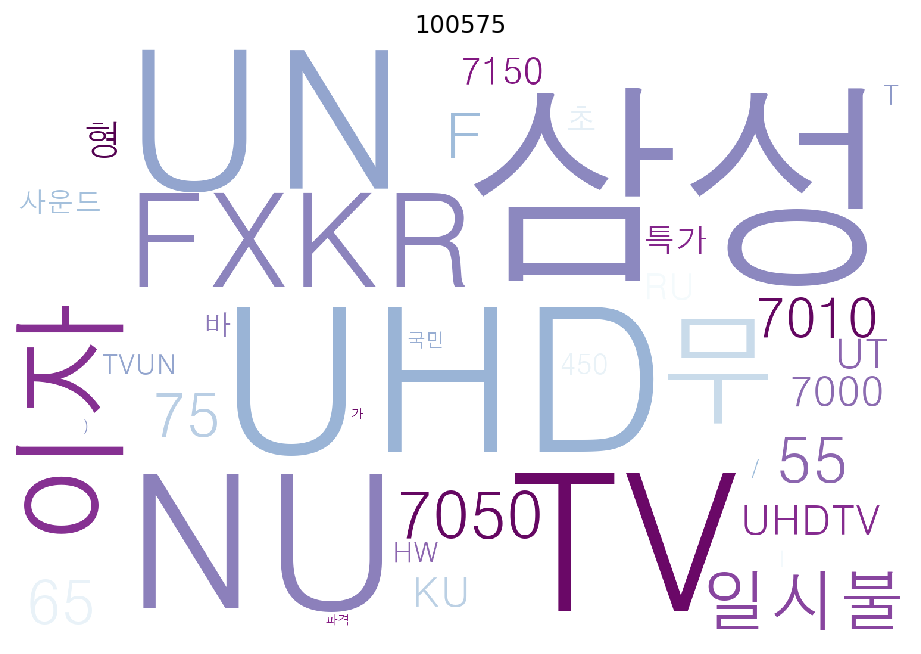

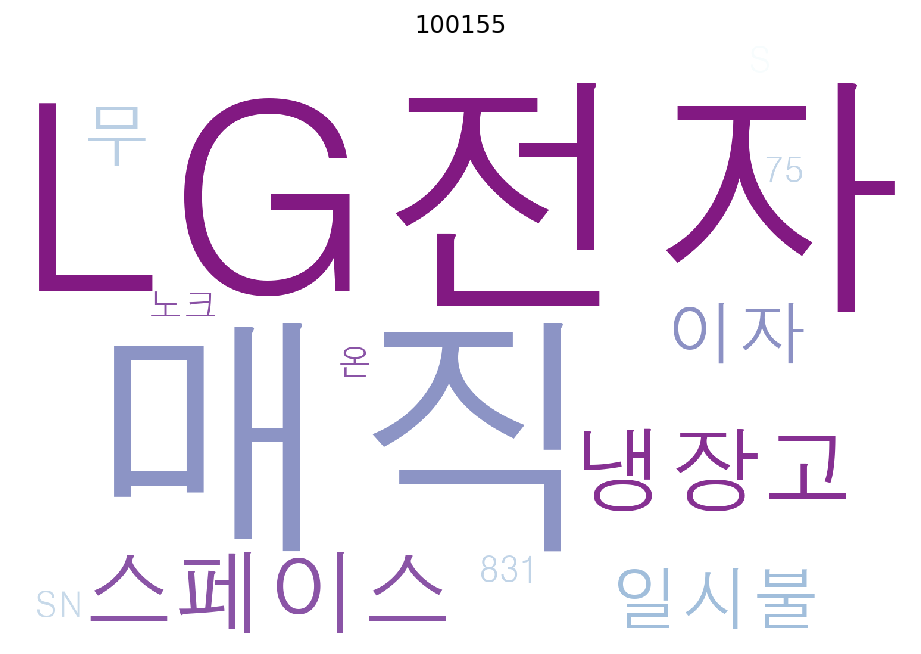

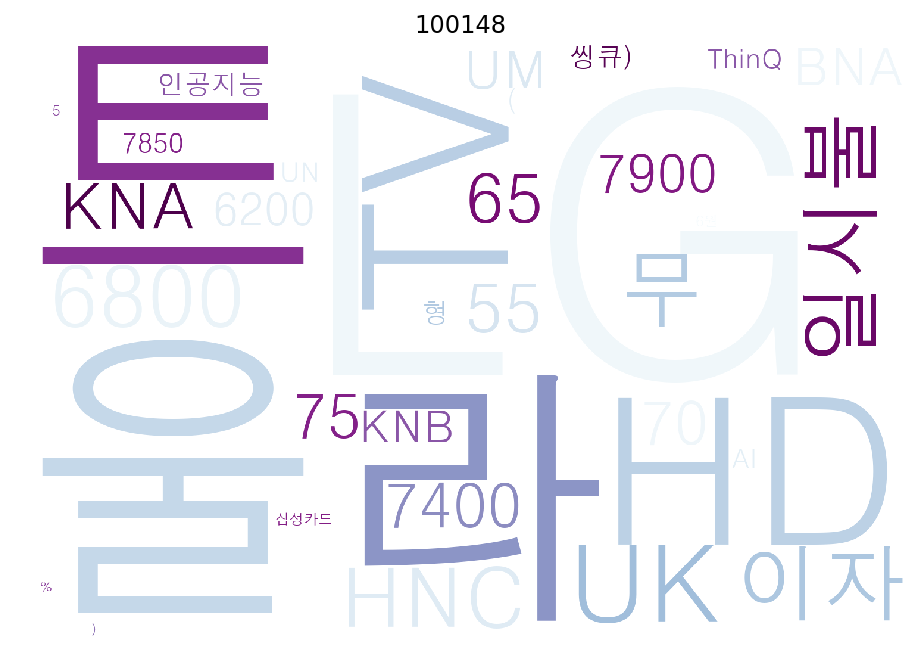

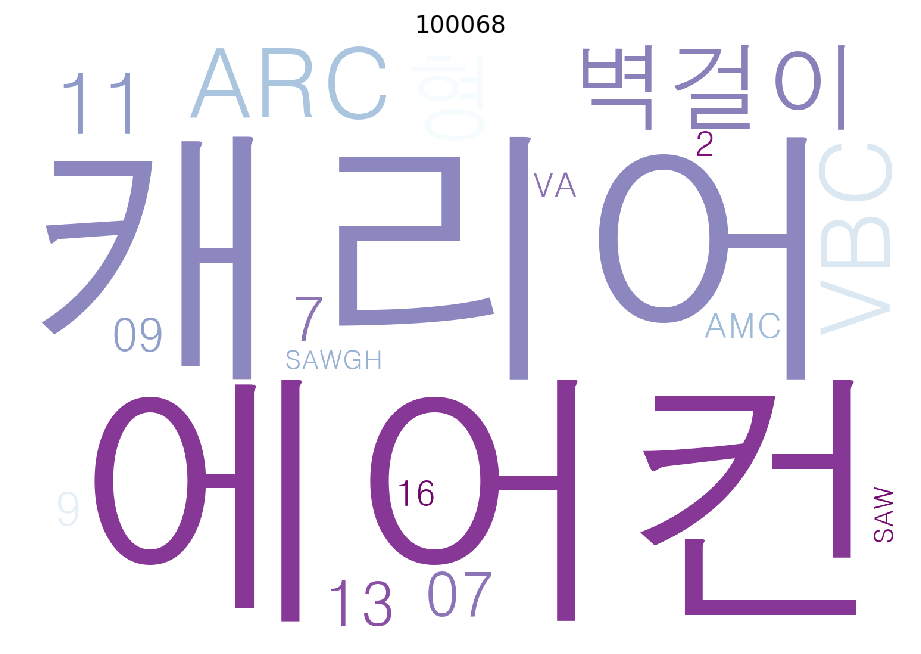

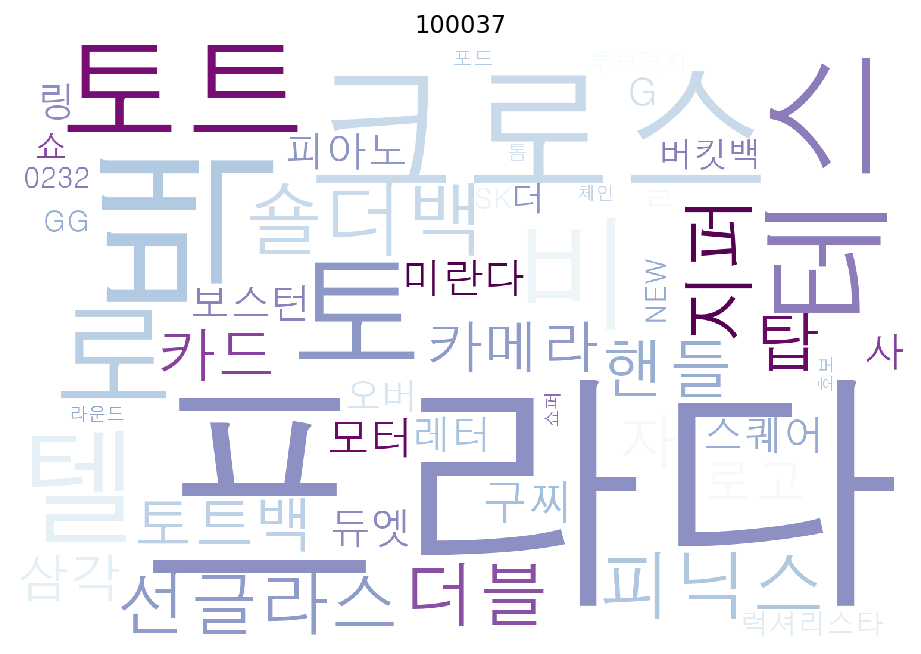

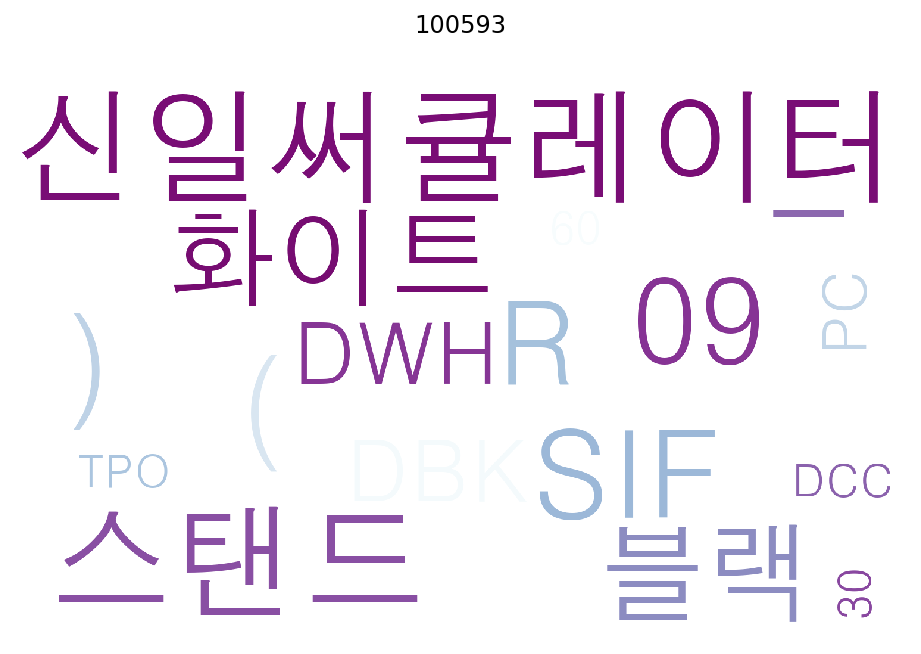

In [209]:
#워드클라우드 시각화
kind = pd.read_csv("../bigcon/sub_prokind_final.csv")
a = kind.groupby('마더코드').count()
mother_most = a.sort_values('상품명', ascending=False).reset_index()['마더코드'].iloc[:6]
from konlpy.tag import Okt

from konlpy.tag import Hannanum
from konlpy.tag import Komoran

okt = Okt()
komoran = Komoran()
hannanum = Hannanum()
for a in mother_most:
    kind_100575 = kind[kind['마더코드']==a]
    list_100575 = kind_100575['상품명'].tolist()
    list_100575 = list_100575 + df.loc[df['mother_code'] == a,'product_name'].tolist()


    words=[]
    for k in list_100575:
        words.append(komoran.morphs(k))


    words_list = []
    
    for i in range(len(words)):
        for j in range(len(words[i])):
            if words[i][j] != '+':
                words_list.append(words[i][j])


    from collections import Counter

    count = Counter(words_list)


    word_cloud = dict(count.most_common())

    wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/H2GTRM.ttf', background_color='white',colormap = "BuPu", width=1500, height=1000).generate_from_frequencies(word_cloud) 
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud) 
    plt.axis('off') 
    plt.title(a)
    plt.show()




    

---
# Modeling

In [281]:
df.fillna(0,inplace=True)
df['temp_date'] = pd.to_datetime(df['date_time'])
#19년 06월~07월 데이터를 test set으로 사용
test_df = df[(df['temp_date'] >= '2019-06-01 00:00:00') & (df['temp_date']<'2019-07-01 00:00:00')]
train_df = df[(df['temp_date'] < '2019-06-01 00:00:00') | (df['temp_date']>='2019-07-01 00:00:00')]
x_train=train_df[['exposure','mother_code','product_code','product_name','product_kind','price_per_unit','year','month',
 'day','time','hour','minute','sex','view_rate','day_date','weekday_name','weekofmonth','week_month','day_year',
 'quarter','tempeture','rain','wind_speed','humidity','atmospheric_pressure','sunlight','solar_radiation','snow',
 'sight','product_cluster','mother_exp_sum','mother_total_sum','mother_order_sum','mother_unit_sum','mother_exp_mean',
 'mother_total_mean','mother_order_mean','mother_unit_mean','mother_exp_median','mother_total_median','mother_order_median',
 'mother_count','mother_total_std','mother_order_std','mother_unit_std','mother_total_25','mother_order_25',
 'mother_total_75','mother_order_75','mother_total_max','mother_order_max','mother_total_min','mother_order_min',
 'product_exp_sum','product_total_sum','product_order_sum','product_unit_sum','product_exp_mean','product_total_mean',
 'product_order_mean','product_unit_mean','product_exp_median','product_total_median','product_order_median',
 'product_count','product_total_std','product_order_std','product_unit_std','product_total_25','product_order_25',
 'product_total_75','product_order_75','product_total_max','product_order_max','product_total_min','product_order_min',
 'product_cluster_total_price_sum','product_cluster_order_quantity_sum','product_cluster_total_price_mean','product_cluster_order_quantity_mean',
 'product_cluster_total_price_median', 'product_cluster_order_quantity_median', 'product_cluster_total_price_std', 'product_cluster_order_quantity_std',
 'product_cluster_total_price_25','product_cluster_order_quantity_25','product_cluster_total_price_75','product_cluster_order_quantity_75','product_cluster_total_price_max','product_cluster_order_quantity_max',
 'product_cluster_total_price_min','product_cluster_order_quantity_min','weekday_name_total_price_sum','weekday_name_order_quantity_sum',
 'weekday_name_total_price_mean','weekday_name_order_quantity_mean',
 'weekday_name_total_price_median', 'weekday_name_order_quantity_median','weekday_name_total_price_std','weekday_name_order_quantity_std','weekday_name_total_price_25',
 'weekday_name_order_quantity_25','weekday_name_total_price_75','weekday_name_order_quantity_75',
 'weekday_name_total_price_max','weekday_name_order_quantity_max',
 'weekday_name_total_price_min','weekday_name_order_quantity_min',
 'day_year_total_price_sum','day_year_order_quantity_sum','day_year_total_price_mean','day_year_order_quantity_mean',
 'day_year_total_price_median','day_year_order_quantity_median','day_year_total_price_std',
 'day_year_order_quantity_std','day_year_total_price_25','day_year_order_quantity_25',
 'day_year_total_price_75','day_year_order_quantity_75','day_year_total_price_max','day_year_order_quantity_max',
 'day_year_total_price_min','day_year_order_quantity_min','hour_total_price_sum','hour_order_quantity_sum',
 'hour_total_price_mean','hour_order_quantity_mean','hour_total_price_median','hour_order_quantity_median',
 'hour_total_price_std','hour_order_quantity_std','hour_total_price_25','hour_order_quantity_25',
 'hour_total_price_75','hour_order_quantity_75','hour_total_price_max','hour_order_quantity_max',
 'hour_total_price_min','hour_order_quantity_min','food_price','life_price','non_food_price']
]

y_train = np.log1p(train_df['total_price'])

x_test=test_df[['exposure','mother_code','product_code','product_name','product_kind','price_per_unit','year','month',
 'day','time','hour','minute','sex','view_rate','day_date','weekday_name','weekofmonth','week_month','day_year',
 'quarter','tempeture','rain','wind_speed','humidity','atmospheric_pressure','sunlight','solar_radiation','snow',
 'sight','product_cluster','mother_exp_sum','mother_total_sum','mother_order_sum','mother_unit_sum','mother_exp_mean',
 'mother_total_mean','mother_order_mean','mother_unit_mean','mother_exp_median','mother_total_median','mother_order_median',
 'mother_count','mother_total_std','mother_order_std','mother_unit_std','mother_total_25','mother_order_25',
 'mother_total_75','mother_order_75','mother_total_max','mother_order_max','mother_total_min','mother_order_min',
 'product_exp_sum','product_total_sum','product_order_sum','product_unit_sum','product_exp_mean','product_total_mean',
 'product_order_mean','product_unit_mean','product_exp_median','product_total_median','product_order_median',
 'product_count','product_total_std','product_order_std','product_unit_std','product_total_25','product_order_25',
 'product_total_75','product_order_75','product_total_max','product_order_max','product_total_min','product_order_min',
 'product_cluster_total_price_sum','product_cluster_order_quantity_sum','product_cluster_total_price_mean','product_cluster_order_quantity_mean',
 'product_cluster_total_price_median', 'product_cluster_order_quantity_median', 'product_cluster_total_price_std', 'product_cluster_order_quantity_std',
 'product_cluster_total_price_25','product_cluster_order_quantity_25','product_cluster_total_price_75','product_cluster_order_quantity_75','product_cluster_total_price_max','product_cluster_order_quantity_max',
 'product_cluster_total_price_min','product_cluster_order_quantity_min','weekday_name_total_price_sum','weekday_name_order_quantity_sum',
 'weekday_name_total_price_mean','weekday_name_order_quantity_mean',
 'weekday_name_total_price_median', 'weekday_name_order_quantity_median','weekday_name_total_price_std','weekday_name_order_quantity_std','weekday_name_total_price_25',
 'weekday_name_order_quantity_25','weekday_name_total_price_75','weekday_name_order_quantity_75',
 'weekday_name_total_price_max','weekday_name_order_quantity_max',
 'weekday_name_total_price_min','weekday_name_order_quantity_min',
 'day_year_total_price_sum','day_year_order_quantity_sum','day_year_total_price_mean','day_year_order_quantity_mean',
 'day_year_total_price_median','day_year_order_quantity_median','day_year_total_price_std',
 'day_year_order_quantity_std','day_year_total_price_25','day_year_order_quantity_25',
 'day_year_total_price_75','day_year_order_quantity_75','day_year_total_price_max','day_year_order_quantity_max',
 'day_year_total_price_min','day_year_order_quantity_min','hour_total_price_sum','hour_order_quantity_sum',
 'hour_total_price_mean','hour_order_quantity_mean','hour_total_price_median','hour_order_quantity_median',
 'hour_total_price_std','hour_order_quantity_std','hour_total_price_25','hour_order_quantity_25',
 'hour_total_price_75','hour_order_quantity_75','hour_total_price_max','hour_order_quantity_max',
 'hour_total_price_min','hour_order_quantity_min','food_price','life_price','non_food_price']
]

y_test = np.log1p(test_df['total_price'])

cat_features = x_train[['mother_code','product_cluster','year','month','day',
'time','hour','minute','sex','view_rate','day_date','weekday_name',
'weekofmonth','week_month','day_year','quarter','product_name','product_kind']]



In [255]:

for i in enumerate (cat_features) :
    ca = i[1] 
    x_train[ca] = x_train[ca].astype('category') 
    x_test[ca] = x_test[ca].astype('category')

    

/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [256]:
import lightgbm as lgb

train_ds = lgb.Dataset(x_train, label = y_train) 
test_ds = lgb.Dataset(x_test, label = y_test) 

params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.98112
[200]	valid_0's l2: 1.15745
[300]	valid_0's l2: 1.04721
[400]	valid_0's l2: 1.04423
Early stopping, best iteration is:
[329]	valid_0's l2: 1.03873


In [260]:
predict_test = model.predict(x_test)

mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)

mae = mean_absolute_error(y_test,predict_test)

print('Mean squared error: ', mse)
print('R2 score: ', r2)
print('mae :', mae)

Mean squared error:  1.0349241891157253
R2 score:  0.8682228745361356
mae : 0.5665324348321544


In [291]:
check = y_test.reset_index()
check['pred'] = predict_test
cal_df = check[check['total_price'] != 0] 
real = cal_df['total_price']
pred = cal_df['pred']

In [316]:
a = np.array(test_df.loc[test_df['total_price']!=0,'total_price'])
b = np.array(np.expm1(pred).astype('int'))
abs((a-b)/a).sum()/len(a)*100

log MAPE : 

In [298]:
abs((real-pred)/real).sum()/len(real)*100

4.025693110517529

MAPE :

In [326]:
abs((a-b)/a).sum()/len(a)*100

326.31175949732625

### 초기 성능평가 결과 MAPE값 : 326

---
# 하이퍼파라미터 튜닝

In [214]:
#매출액이 없는 무형 상품군과 50000보다 큰 상품만 모델 학습에 사용
intan_df = df[df['product_kind'] != '무형']
intan_df_over_5 = intan_df[(intan_df['total_price'] > 50000)]
intan_df_over_5.fillna(0,inplace=True)

x=intan_df_over_5[['exposure','mother_code','product_code','price_per_unit','year','month',
 'day','hour','minute','view_rate','weekday_name','weekofmonth','week_month','day_year',
 'quarter','tempeture','rain','wind_speed','humidity','atmospheric_pressure','sunlight','solar_radiation','snow',
 'sight','product_cluster','mother_exp_sum','mother_total_sum','mother_order_sum','mother_unit_sum','mother_exp_mean',
 'mother_total_mean','mother_order_mean','mother_unit_mean','mother_exp_median','mother_total_median','mother_order_median',
 'mother_count','mother_total_std','mother_order_std','mother_unit_std','mother_total_25','mother_order_25',
 'mother_total_75','mother_order_75','mother_total_max','mother_order_max','mother_total_min','mother_order_min',
 'product_exp_sum','product_total_sum','product_order_sum','product_unit_sum','product_exp_mean','product_total_mean',
 'product_order_mean','product_unit_mean','product_exp_median','product_total_median','product_order_median',
 'product_count','product_total_std','product_order_std','product_unit_std','product_total_25','product_order_25',
 'product_total_75','product_order_75','product_total_max','product_order_max','product_total_min','product_order_min',
 'product_cluster_total_price_sum','product_cluster_order_quantity_sum','product_cluster_total_price_mean','product_cluster_order_quantity_mean',
 'product_cluster_total_price_median', 'product_cluster_order_quantity_median', 'product_cluster_total_price_std', 'product_cluster_order_quantity_std',
 'product_cluster_total_price_25','product_cluster_order_quantity_25','product_cluster_total_price_75','product_cluster_order_quantity_75','product_cluster_total_price_max','product_cluster_order_quantity_max',
 'product_cluster_total_price_min','product_cluster_order_quantity_min','weekday_name_total_price_sum','weekday_name_order_quantity_sum',
 'weekday_name_total_price_mean','weekday_name_order_quantity_mean',
 'weekday_name_total_price_median', 'weekday_name_order_quantity_median','weekday_name_total_price_std','weekday_name_order_quantity_std','weekday_name_total_price_25',
 'weekday_name_order_quantity_25','weekday_name_total_price_75','weekday_name_order_quantity_75',
 'weekday_name_total_price_max','weekday_name_order_quantity_max',
 'weekday_name_total_price_min','weekday_name_order_quantity_min',
 'day_year_total_price_sum','day_year_order_quantity_sum','day_year_total_price_mean','day_year_order_quantity_mean',
 'day_year_total_price_median','day_year_order_quantity_median','day_year_total_price_std',
 'day_year_order_quantity_std','day_year_total_price_25','day_year_order_quantity_25',
 'day_year_total_price_75','day_year_order_quantity_75','day_year_total_price_max','day_year_order_quantity_max',
 'day_year_total_price_min','day_year_order_quantity_min','hour_total_price_sum','hour_order_quantity_sum',
 'hour_total_price_mean','hour_order_quantity_mean','hour_total_price_median','hour_order_quantity_median',
 'hour_total_price_std','hour_order_quantity_std','hour_total_price_25','hour_order_quantity_25',
 'hour_total_price_75','hour_order_quantity_75','hour_total_price_max','hour_order_quantity_max',
 'hour_total_price_min','hour_order_quantity_min','food_price','life_price','non_food_price']
]

y = np.log1p(intan_df_over_5['total_price'])


train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=42)

cat_features = train_x[['mother_code','product_cluster','year','month','day',
'hour','minute','view_rate','weekday_name',
'weekofmonth','week_month','day_year','quarter']]

for i in enumerate (cat_features) :
    ca = i[1] 
    train_x[ca] = train_x[ca].astype('category') 
    test_x[ca] = test_x[ca].astype('category')



/Users/eastone/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [223]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3



import lightgbm as lgb

train_ds = lgb.Dataset(train_x, label = train_y) 
test_ds = lgb.Dataset(test_x, label = test_y) 

fit_params = {
          'eval_metric': {'neg_median_absolute_error'}, 
          'eval_set': [(test_x,test_y)], 
          'eval_names': ['valid'], 
          'verbose': 100,
          'categorical_feature': 'auto',
          #   'callbacks':[lgb.reset_parameter(learning_rate= learning_rate_010_decay_power_099)],
            }



In [224]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test = {'num_leaves':sp_randint(6,50),
             'min_child_samples':sp_randint(100,500),
             'min_child_weight':[1e-5,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4],
             'subsample': sp_uniform(loc=0.4,scale=0.6),
             'reg_alpha':[0, 1e-1,1,2,5,7,10,50,100],
             'reg_lambda':[0,1e-1,1,5,10,20,50,100] }

In [225]:
n_HP_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='neg_median_absolute_error', n_jobs=4,n_estimators=5000)
gs = RandomizedSearchCV(estimator=clf,
                       param_distributions=param_test,
                       n_iter=n_HP_points_to_test,
                       scoring='neg_median_absolute_error',
                       cv=3,
                       refit=True,
                       random_state=314,
                       verbose=True)

In [89]:
gs.fit(train_x,train_y,**fit_params)
print('Best score : {} with params : {}'.format(gs.best_score_,gs.best_params_))



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 182.0min finished


Best score : -0.3185279057938792 with params : {'min_child_samples': 126, 'min_child_weight': 0.001, 'num_leaves': 48, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.4069723302927888}


In [91]:
opt_parameters = gs.best_params_

In [94]:
clf_sw= lgb.LGBMRegressor(**clf.get_params())
clf_sw.set_params(**opt_parameters)


LGBMRegressor(metric='neg_median_absolute_error', min_child_samples=126,
              n_estimators=5000, n_jobs=4, num_leaves=48, random_state=314,
              reg_alpha=1, reg_lambda=0.1, subsample=0.4069723302927888)

In [116]:
gs_sample_weight = GridSearchCV(estimator=clf_sw,
                               param_grid={'scale_pos_weight':[1,2,6,12]},
                               scoring='neg_median_absolute_error',
                                cv=5,
                                refit=True,
                                verbose=True
                               )


In [121]:
gs_sample_weight.fit(train_x,train_y,**fit_params)
print('Best score reached : {} with params: {}'.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 14.7min finished


Best score reached : -0.29006905667173655 with params: {'scale_pos_weight': 1}


In [216]:
clf_final = lgb.LGBMRegressor(**clf.get_params())

clf_final.set_params(**opt_parameters)

clf_final.fit(train_x,train_y,**fit_params, callbacks=[lgb.reset_parameter(learning_rate = learning_rate_010_decay_power_0995)])



LGBMRegressor(metric='neg_median_absolute_error', min_child_samples=126,
              n_estimators=5000, n_jobs=4, num_leaves=48, random_state=314,
              reg_alpha=1, reg_lambda=0.1, subsample=0.4069723302927888)

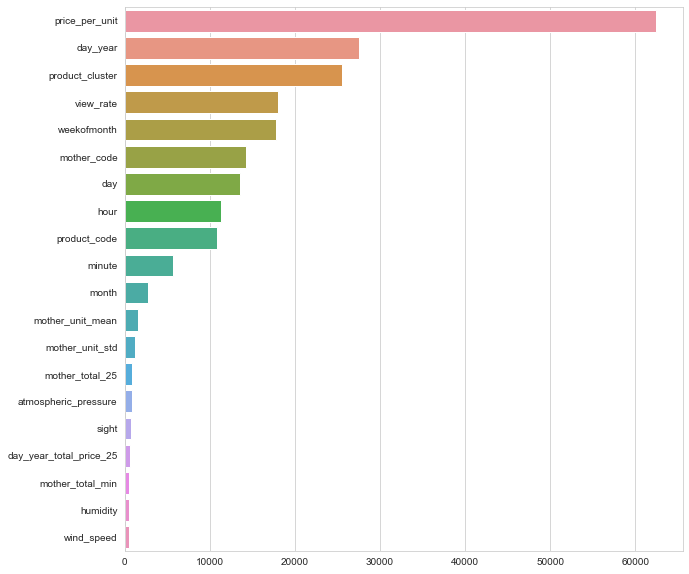

In [217]:
plt.figure(figsize=(10,10))
sns.barplot(feat_imp.nlargest(20),feat_imp.nlargest(20).index)


In [218]:
pred = clf_final.predict(test_x)


In [219]:
pred = clf_final.predict(test_x)
check = test_y.reset_index()
check['pred'] = pred
cal_df = check[check['total_price'] != 0] 
real = cal_df['total_price']
pred = cal_df['pred']
print('MAPE : ',abs((exp_real-exp_pred)/exp_real).sum()/len(real)*100)
print('log MAPE : ',abs((real-pred)/real).sum()/len(real)*100)

In [220]:
print('log MAPE : ',abs((real-pred)/real).sum()/len(real)*100)

log MAPE :  2.142326594706376


In [221]:
exp_real = np.expm1(real)
exp_pred = np.expm1(pred)
print('MAPE : ',abs((exp_real-exp_pred)/exp_real).sum()/len(real)*100)

MAPE :  41.26755584053895


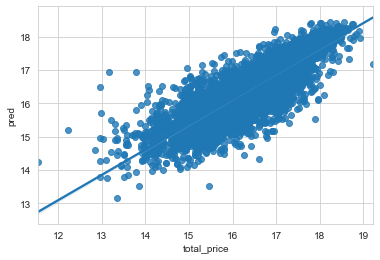

In [222]:
sns.regplot(x = real, y = pred)

# 하이퍼파라미터 튜닝 후 예측결과

### MAPE : 41

# 최종모델링

In [9]:
df = pd.read_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/최종train_0915.csv')
sub = pd.read_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/최종sub_0915.csv')



In [209]:
#상품 가격이 0이 아닌 데이터만 학습
df_zero = df[df['total_price'] !=0]

In [ ]:
#모델 학습에 필요한 변수이름만 추출
a = df_zero.columns.tolist()
remove_list =['total_price','date','date_time','price_per_exposure','round_date','order_quantity','fake_time']
for r in remove_list:
    a.remove(r)
    print(r)
a

In [ ]:
remove_list = ['total_price','date','round_date']
b = sub.columns.tolist()

for r in remove_list:
    b.remove(r)
    print(r)
b

In [219]:
#종속변수인 매출액에 Log를 취함
x = df_zero[a]
y = np.log1p(df_zero['total_price'])

train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=42)

cat_features = train_x[['mother_code','product_code','product_name','product_kind','product_cluster','year','month','day',
'hour','time','day_date','sex','week_year','minute','view_rate','weekday_name',
'week_month','week_month','day_year','quarter']]

for i in enumerate (cat_features) :
    ca = i[1] 
    train_x[ca] = train_x[ca].astype('category') 
    test_x[ca] = test_x[ca].astype('category')

/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [226]:
import lightgbm as lgb
clf_final = lgb.LGBMRegressor(metric='neg_median_absolute_error', min_child_samples=132,
              min_child_weight=1, n_estimators=5000, n_jobs=4, num_leaves=45,
              random_state=314, reg_alpha=10, reg_lambda=100,
              subsample=0.44566665700605484)

#clf_final.set_params(**opt_parameters)

clf_final.fit(train_x,train_y,**fit_params, callbacks=[lgb.reset_parameter(learning_rate = learning_rate_010_decay_power_0995)])



LGBMRegressor(metric='neg_median_absolute_error', min_child_samples=132,
              min_child_weight=1, n_estimators=5000, n_jobs=4, num_leaves=45,
              random_state=314, reg_alpha=10, reg_lambda=100,
              subsample=0.44566665700605484)

In [125]:
clf_final = lgb.LGBMRegressor(**clf.get_params())

clf_final.set_params(**opt_parameters)

clf_final.fit(train_x,train_y,**fit_params, callbacks=[lgb.reset_parameter(learning_rate = learning_rate_010_decay_power_0995)])



LGBMRegressor(metric='neg_median_absolute_error', min_child_samples=132,
              min_child_weight=1, n_estimators=5000, n_jobs=4, num_leaves=45,
              random_state=314, reg_alpha=10, reg_lambda=100,
              subsample=0.44566665700605484)

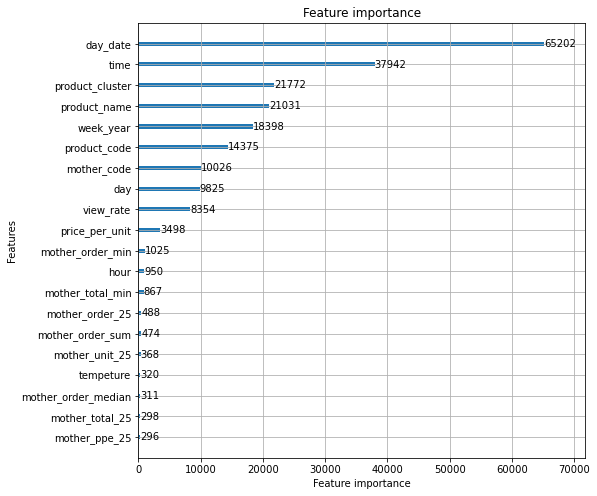

In [78]:
lgb.plot_importance(clf_final,max_num_features=20,figsize=(8,8))

Feature importance 시각화

In [79]:
pred = clf_final.predict(test_x)
check = test_y.reset_index()
check['pred'] = pred
real = check['total_price']
pred = check['pred']
exp_real = np.expm1(real)
exp_pred = np.expm1(pred)
print('MAPE : ',abs((exp_real-exp_pred)/exp_real).sum()/len(real)*100)
print('log MAPE : ',abs((real-pred)/real).sum()/len(real)*100)

MAPE :  37.045628179755354
log MAPE :  2.001637052178572


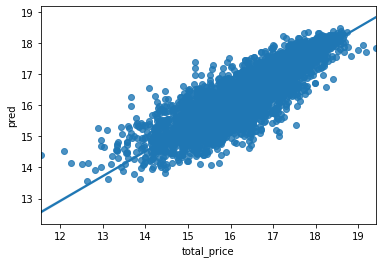

In [80]:
sns.regplot(x = real, y = pred)

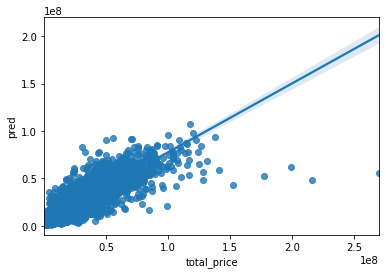

In [81]:
sns.regplot(x = exp_real, y = exp_pred)

로그 취했던 종속변수를 지수화하여 시각화

In [106]:
sub_2 = sub[sub['product_kind'] != '무형']
sub_test_x= sub_2[b]
for i in enumerate (cat_features) :
    ca = i[1] 
    
    sub_test_x[ca] = sub_test_x[ca].astype('category')

/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
sub_pred = clf_final.predict(sub_test_x)
sub_2['total_price'] = np.expm1(sub_pred)

/Users/eastone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [112]:
sub_2

,date_x,exposure,product_code,product_name,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute,round_date,view_rate,day_date,weekday_name,week_year,day_year,quarter,week_month,food_price,life_price,non_food_price,tempeture,rain,wind_speed,humidity,atmospheric_pressure,sunlight,solar_radiation,snow,sight,product_cluster,sex,mother_code,mother_exp_sum,mother_total_sum,mother_order_sum,mother_unit_sum,mother_ppe_sum,mother_view_sum,mother_exp_mean,mother_total_mean,mother_order_mean,mother_unit_mean,mother_ppe_mean,mother_view_mean,mother_exp_median,mother_total_median,mother_order_median,mother_unit_median,mother_ppe_median,mother_view_median,mother_count,mother_total_std,mother_order_std,mother_unit_std,mother_ppe_std,mother_view_std,mother_total_25,mother_order_25,mother_unit_25,mother_ppe_25,mother_view_25,mother_total_75,mother_order_75,mother_unit_75,mother_ppe_75,mother_view_75,mother_total_max,mother_order_max,mother_unit_max,mother_ppe_max,mother_view_max,mother_total_min,mother_order_min,mother_unit_min,mother_ppe_min,mother_view_min,product_exp_sum,product_total_sum,product_order_sum,product_unit_sum,product_ppe_sum,product_view_sum,product_exp_mean,product_total_mean,product_order_mean,product_unit_mean,product_ppe_mean,product_view_mean,product_exp_median,product_total_median,product_order_median,product_unit_median,product_ppe_median,product_view_median,product_count,product_total_std,...,sex_total_price_min,sex_order_quantity_min,sex_price_per_unit_min,sex_view_rate_min,week_year_total_price_sum,week_year_order_quantity_sum,week_year_price_per_unit_sum,week_year_view_rate_sum,week_year_total_price_mean,week_year_order_quantity_mean,week_year_price_per_unit_mean,week_year_view_rate_mean,week_year_total_price_median,week_year_order_quantity_median,week_year_price_per_unit_median,week_year_view_rate_median,week_year_total_price_std,week_year_order_quantity_std,week_year_price_per_unit_std,week_year_view_rate_std,week_year_total_price_25,week_year_order_quantity_25,week_year_price_per_unit_25,week_year_view_rate_25,week_year_total_price_75,week_year_order_quantity_75,week_year_price_per_unit_75,week_year_view_rate_75,week_year_total_price_max,week_year_order_quantity_max,week_year_price_per_unit_max,week_year_view_rate_max,week_year_total_price_min,week_year_order_quantity_min,week_year_price_per_unit_min,week_year_view_rate_min,week_month_total_price_sum,week_month_order_quantity_sum,week_month_price_per_unit_sum,week_month_view_rate_sum,week_month_total_price_mean,week_month_order_quantity_mean,week_month_price_per_unit_mean,week_month_view_rate_mean,week_month_total_price_median,week_month_order_quantity_median,week_month_price_per_unit_median,week_month_view_rate_median,week_month_total_price_std,week_month_order_quantity_std,week_month_price_per_unit_std,week_month_view_rate_std,week_month_total_price_25,week_month_order_quantity_25,week_month_price_per_unit_25,week_month_view_rate_25,week_month_total_price_75,week_month_order_quantity_75,week_month_price_per_unit_75,week_month_view_rate_75,week_month_total_price_max,week_month_order_quantity_max,week_month_price_per_unit_max,week_month_view_rate_max,week_month_total_price_min,week_month_order_quantity_min,week_month_price_per_unit_min,week_month_view_rate_min,quarter_total_price_sum,quarter_order_quantity_sum,quarter_price_per_unit_sum,quarter_view_rate_sum,quarter_total_price_mean,quarter_order_quantity_mean,quarter_price_per_unit_mean,quarter_view_rate_mean,quarter_total_price_median,quarter_order_quantity_median,quarter_price_per_unit_median,quarter_view_rate_median,quarter_total_price_std,quarter_order_quantity_std,quarter_price_per_unit_std,quarter_view_rate_std,quarter_total_price_25,quarter_order_quantity_25,quarter_price_per_unit_25,quarter_view_rate_25,quarter_total_price_75,quarter_order_quantity_75,quarter_price_per_unit_75,quarter_view_rate_75,quarter_total_price_max,quarter_order_quantity_max,quarter_price_per_unit_max,quarter_vie

In [146]:


import shap

explainer =shap.TreeExplainer(clf_final)

In [166]:
row_to_show = 5
data_for_prediction = test_x.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1,-1)

shap_values_test = explainer.shap_values(test_x)
shap_values_train = explainer.shap_values(train_x)
#clf_final.predict(data_for_prediction)


In [168]:
j = 0
shap.initjs()

#shap.force_plot(explainer.expected_value, shap_values[j])

In [170]:
j = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[j],test_x.iloc[[j]])

베이스 밸류 값은 16.55이며 예측값은 16.53이다 예측값을 높은 값으로 만드는 feature들은 빨강색 낮은 값으로 만드는 feature들은 파란색에 해당한다. 또한 가장 큰 영향을 끼치는 것은 mother_total_25 변수이고 상품명 변수와 시간 또한 큰 영향을 미치고 있다. 

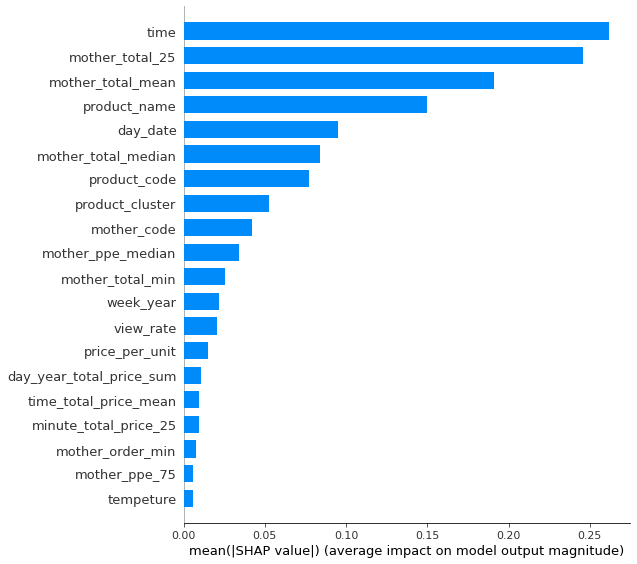

In [183]:
shap.summary_plot(shap_values_train,train_x,plot_type='bar')

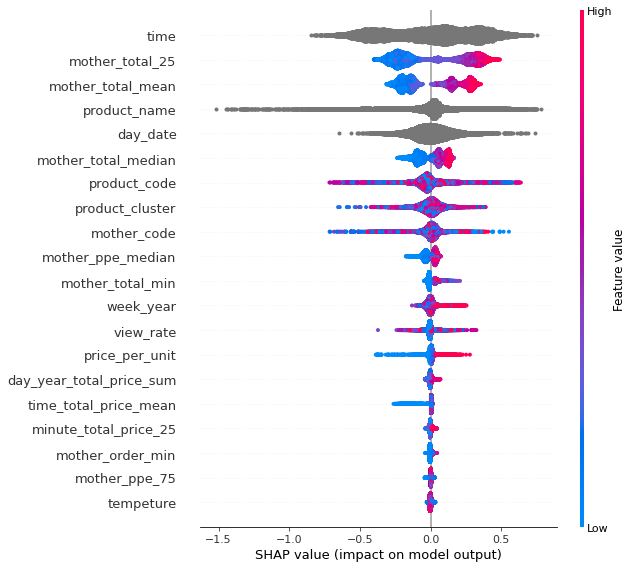

In [184]:
shap.summary_plot(shap_values_train,train_x)

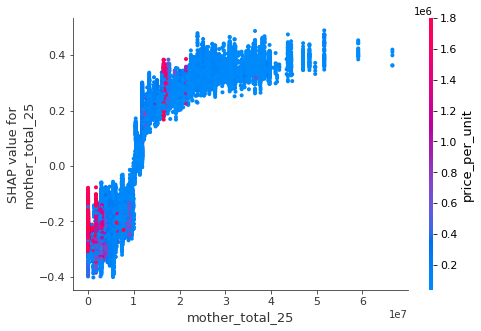

In [188]:
shp_plt = shap.dependence_plot("mother_total_25",shap_values_train,train_x)

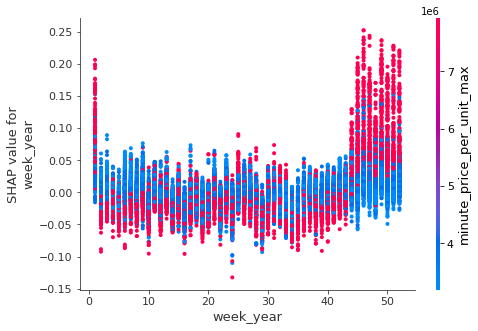

In [190]:
shp_plt = shap.dependence_plot("week_year",shap_values_train,train_x)

## 

## sub 데이터프레임에 예측값을 대입하고 상품군이 무형인 상품들은 0 대입

In [218]:
new_sub.to_csv('../data/bigcon/최종예측값.csv',index=False)

In [297]:
sub = pd.read_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/최종예측값.csv')
sub['total_price']

0       6.932545e+06
1       1.891027e+07
2       5.743905e+07
3       7.631704e+07
4       7.139024e+07
            ...     
2870    6.113268e+07
2871    7.083416e+07
2872    0.000000e+00
2873    0.000000e+00
2874    0.000000e+00
Name: total_price, Length: 2875, dtype: float64

In [315]:
col_list = sub.iloc[:,1:6].columns.tolist() + ['date_x','total_price']
final_sub = sub[col_list]
final_sub.rename({'date_x':'date'},axis=1,inplace=True)

/Users/eastone/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [324]:
empty_sub['pred_price'] = np.expm1(empty_pred)
col_list = sub.iloc[:,1:6].columns.tolist() + ['date','pred_price']
final_empty = empty_sub[col_list]
final_empty.rename({'pred_price':'total_price'},axis=1,inplace=True)

/Users/eastone/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [325]:
sub_concat= pd.concat([final_sub,final_empty])

In [326]:
sub_concat

,exposure,product_code,product_name,product_kind,price_per_unit,date,total_price
0,20.0,201971,잭필드 남성 반팔셔츠 4종,의류,59800,2020-06-01 06:20:00,6.932545e+06
1,20.0,202128,월드컵 S/S 남성 에어러닝화+패션슬리퍼,잡화,29800,2020-06-06 06:20:00,1.891027e+07
2,20.0,201595,예작 남성 썸머셔츠 3종,의류,119000,2020-06-05 18:20:00,5.743905e+07
3,20.0,201319,코몽트 남성 티셔츠 8종(시즌1),의류,39900,2020-06-01 19:20:00,7.631704e+07
4,20.0,201033,[VONIN]보닌 남성기초세트(워터로션),이미용,54000,2020-06-03 19:20:00,7.139024e+07
...,...,...,...,...,...,...,...
11,15.0,202039,영광법성포굴비20마리,농수축,40900,2020-06-22 10:05:00,1.375985e+07
12,15.0,202042,영광법성포굴비35마리,농수축,30900,2020-06-28 09:35:00,1.375985e+07
13,15.0,202040,영광법성포굴비20마리,농수축,40900,2020-06-28 09:35:00,1.375985e+07
14,15.0,202042,영광법성포굴비35마리,농수축,30900,2020-06-28 10:05:00,1.375985e+07


In [327]:
sub_concat['code'] = sub_concat['date'] + sub_concat['product_code'].astype('str')
submission['방송일시'] = pd.to_datetime(submission['방송일시'])
submission['code'] = submission['방송일시'].astype('str') + submission['상품코드'].astype('str')

In [333]:
final_submission= pd.merge(submission,sub_concat[['code','total_price']],on='code')
final_submission.drop(['취급액','code'],axis=1,inplace=True)

In [367]:
final_submission.rename({'total_price':'취급액'},axis=1,inplace=True)
final_submission

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",6.932545e+06
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",6.834932e+06
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",6.932227e+06
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",7.092649e+07
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",7.297450e+07
...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,0.000000e+00
2887,2020-07-01 00:40:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,0.000000e+00
2888,2020-07-01 01:00:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,0.000000e+00
2889,2020-07-01 01:20:00,20.0,100261,200875,아놀드파마 티셔츠레깅스세트,의류,"69,900",6.113268e+07


In [368]:
final_submission.to_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/최종_submission_0925.csv',index=False )

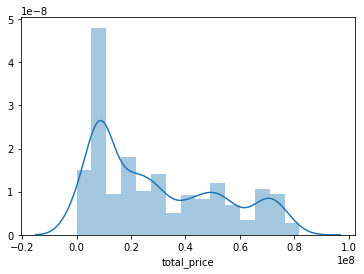

In [334]:
sns.distplot(final_submission['total_price'])

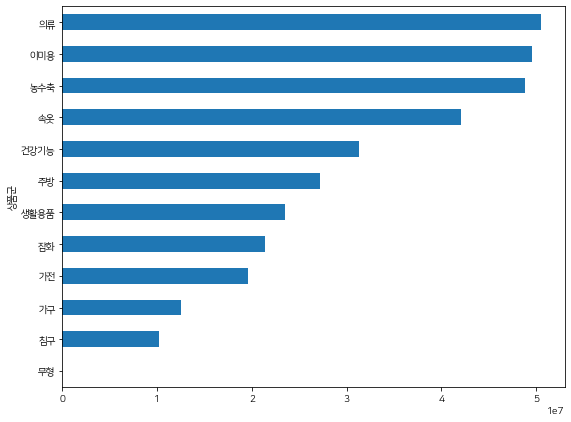

In [350]:
plt.figure(figsize=(9,7))
final_submission.groupby('상품군').mean()['total_price'].sort_values().plot(kind='barh')

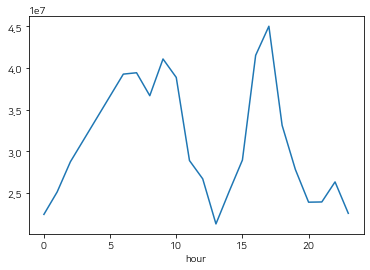

In [362]:
sub.groupby('hour').mean()['total_price'].plot()
#13시경에 매출액이 낮은 것은 상품군이 무형이 제품이 많아 평균을 떨어뜨리기 때문

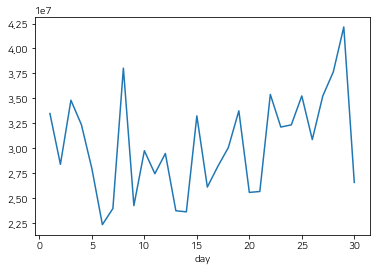

In [365]:
sub.groupby('day').mean()['total_price'].plot()

In [27]:
submission = pd.read_csv('../bigcon/sub.csv', encoding='CP949')
submission

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 6:20,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
1,2020-06-01 6:40,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
2,2020-06-01 7:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
3,2020-06-01 7:20,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
4,2020-06-01 7:40,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
...,...,...,...,...,...,...,...,...
2886,2020-07-01 0:20,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2887,2020-07-01 0:40,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2888,2020-07-01 1:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2889,2020-07-01 1:20,20.0,100261,200875,아놀드파마 티셔츠레깅스세트,의류,"69,900",NaN


In [25]:
a =pd.read_csv('/Users/eastone/Desktop/UCA/progrmming_in_python/data/bigcon/최종sub_0915.csv')
a = a.sort_values('date_x')

In [28]:
a['code'] = a['date_x'] + a['product_code'].astype('str')
submission['방송일시'] = pd.to_datetime(submission['방송일시'])
submission['code'] = submission['방송일시'].astype('str') + submission['상품코드'].astype('str')

In [201]:
a['code']

0       2020-06-01 06:20:00201971
12      2020-06-01 06:40:00201971
23      2020-06-01 07:00:00201971
46      2020-06-01 07:20:00202278
59      2020-06-01 07:40:00202278
                  ...            
2872    2020-07-01 00:20:00201989
2873    2020-07-01 00:40:00201989
2874    2020-07-01 01:00:00201989
2870    2020-07-01 01:20:00200875
2871    2020-07-01 01:40:00200875
Name: code, Length: 2875, dtype: object

In [29]:
empty = submission[~submission['code'].isin(a['code'])].index

In [32]:
submission.loc[empty]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,code
251,2020-06-03 23:35:00,15.0,100281,201011,에버라스트 스텐다드 드로즈 10+4종(2020),속옷,"39,900",NaN,2020-06-03 23:35:00201011
253,2020-06-04 00:05:00,15.0,100281,201011,에버라스트 스텐다드 드로즈 10+4종(2020),속옷,"39,900",NaN,2020-06-04 00:05:00201011
811,2020-06-09 09:35:00,15.0,100686,202042,영광법성포굴비35마리,농수축,"30,900",NaN,2020-06-09 09:35:00202042
812,2020-06-09 09:35:00,NaN,100686,202040,영광법성포굴비20마리,농수축,"40,900",NaN,2020-06-09 09:35:00202040
815,2020-06-09 10:05:00,15.0,100686,202042,영광법성포굴비35마리,농수축,"30,900",NaN,2020-06-09 10:05:00202042
816,2020-06-09 10:05:00,NaN,100686,202040,영광법성포굴비20마리,농수축,"40,900",NaN,2020-06-09 10:05:00202040
1982,2020-06-21 00:35:00,15.0,100281,201011,에버라스트 스텐다드 드로즈 10+4종(2020),속옷,"39,900",NaN,2020-06-21 00:35:00201011
1984,2020-06-21 01:05:00,15.0,100281,201011,에버라스트 스텐다드 드로즈 10+4종(2020),속옷,"39,900",NaN,2020-06-21 01:05:00201011
2114,2020-06-22 09:35:00,15.0,100686,202041,영광법성포굴비35마리,농수축,"30,900",NaN,2020-06-22 09:35:00202041
2115,2020-06-22 09:35:00,NaN,100686,202039,영광법성포굴비20마리,농수축,"40,900",NaN,2020-06-22 09:35:00202039


In [61]:
empty_sub = sub.loc[empty]

In [72]:
month_data = pd.DataFrame(df[df['month'] ==6].iloc[0,255:287]).transpose()
empty_sub[month_data.columns.tolist()] = month_data.iloc[0].tolist()

In [163]:
empty_sub[day_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    day_data = pd.DataFrame(df[df['day'] == empty_sub['day'].iloc[i]].iloc[0,223:255]).transpose()
    
    empty_sub.loc[i,day_data.columns.tolist()] = day_data.iloc[0].tolist()

In [164]:
empty_sub['fake_time'] = pd.to_datetime(empty_sub['time']).dt.round('10min').dt.time.astype('str')

time_data = pd.DataFrame(df[df['time'] == empty_sub['fake_time'].iloc[0]].iloc[0,287:319]).transpose()
empty_sub[time_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    time_data = pd.DataFrame(df[df['time'] == empty_sub['fake_time'].iloc[i]].iloc[0,287:319]).transpose()
    
    empty_sub.loc[i,time_data.columns.tolist()] = time_data.iloc[0].tolist()

In [168]:
hour_data = pd.DataFrame(df[df['hour'] == empty_sub['hour'].iloc[0]].iloc[0,319:351]).transpose()
empty_sub[hour_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    hour_data = pd.DataFrame(df[df['hour'] == empty_sub['hour'].iloc[i]].iloc[0,319:351]).transpose()
    
    empty_sub.loc[i,hour_data.columns.tolist()] = hour_data.iloc[0].tolist()

In [171]:
minute_data = pd.DataFrame(df[df['minute'] == empty_sub['minute'].iloc[0]].iloc[0,351:383]).transpose()
empty_sub[minute_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    minute_data = pd.DataFrame(df[df['minute'] == empty_sub['minute'].iloc[i]].iloc[0,351:383]).transpose()
    
    empty_sub.loc[i,minute_data.columns.tolist()] = minute_data.iloc[0].tolist()

In [174]:
sex_data = pd.DataFrame(df[df['sex'] == empty_sub['sex'].iloc[0]].iloc[0,383:415]).transpose()
empty_sub[sex_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    sex_data = pd.DataFrame(df[df['sex'] == empty_sub['sex'].iloc[i]].iloc[0,383:415]).transpose()
    
    empty_sub.loc[i,sex_data.columns.tolist()] = sex_data.iloc[0].tolist()

In [177]:
weekyear_data = pd.DataFrame(df[df['week_year'] == empty_sub['week_year'].iloc[0]].iloc[0,415:447]).transpose()
empty_sub[weekyear_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    weekyear_data = pd.DataFrame(df[df['week_year'] == empty_sub['week_year'].iloc[i]].iloc[0,415:447]).transpose()
    
    empty_sub.loc[i,weekyear_data.columns.tolist()] = weekyear_data.iloc[0].tolist()

In [182]:
weekmonth_data = pd.DataFrame(df[df['week_month'] == empty_sub['week_month'].iloc[0]].iloc[0,447:479]).transpose()
empty_sub[weekmonth_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    weekmonth_data = pd.DataFrame(df[df['week_month'] == empty_sub['week_month'].iloc[i]].iloc[0,447:479]).transpose()
    
    empty_sub.loc[i,weekmonth_data.columns.tolist()] = weekmonth_data.iloc[0].tolist()

In [193]:
weekday_data = pd.DataFrame(df[df['weekday_name'] == empty_sub['weekday_name'].iloc[0]].iloc[0,159:191]).transpose()
empty_sub[weekday_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    weekday_data = pd.DataFrame(df[df['weekday_name'] == empty_sub['weekday_name'].iloc[i]].iloc[0,159:191]).transpose()
    
    empty_sub.loc[i,weekday_data.columns.tolist()] = weekday_data.iloc[0].tolist()

In [196]:
cluster_data = pd.DataFrame(df[df['product_cluster'] == empty_sub['product_cluster'].iloc[0]].iloc[0,127:159]).transpose()
empty_sub[cluster_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    cluster_data = pd.DataFrame(df[df['product_cluster'] == empty_sub['product_cluster'].iloc[i]].iloc[0,127:159]).transpose()
    
    empty_sub.loc[i,cluster_data.columns.tolist()] = cluster_data.iloc[0].tolist()

In [200]:
quarter_data = pd.DataFrame(df[df['quarter'] == empty_sub['quarter'].iloc[0]].iloc[0,479:511]).transpose()
empty_sub[quarter_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    quarter_data = pd.DataFrame(df[df['quarter'] == empty_sub['quarter'].iloc[i]].iloc[0,479:511]).transpose()
    
    empty_sub.loc[i,quarter_data.columns.tolist()] = quarter_data.iloc[0].tolist()

In [257]:
dayyear_data = pd.DataFrame(df[df['day_year'] == empty_sub['day_year'].iloc[0]].iloc[0,191:223]).transpose()
empty_sub[dayyear_data.columns.tolist()] = None
for i in range(len(empty_sub)):
    dayyear_data = pd.DataFrame(df[df['day_year'] == empty_sub['day_year'].iloc[i]].iloc[0,191:223]).transpose()
    
    empty_sub.loc[i,dayyear_data.columns.tolist()] = dayyear_data.iloc[0].tolist()

In [261]:
empty_merge = pd.merge(empty_sub,mother_master,on='mother_code',how='left')
empty_final = pd.merge(empty_merge,product_master,left_on='product_kind',right_on='product_name',how='left')
empty_final

,index,date,exposure,product_code,product_name_x,product_kind,price_per_unit,total_price,year,month,day,time,hour,minute,round_date,view_rate,day_date,weekday_name,week_year,day_year,quarter,week_month,food_price,life_price,non_food_price,tempeture,rain,wind_speed,humidity,atmospheric_pressure,sunlight,solar_radiation,snow,sight,product_cluster,mother_code,sex,month_total_price_sum,month_order_quantity_sum,month_price_per_unit_sum,month_view_rate_sum,month_total_price_mean,month_order_quantity_mean,month_price_per_unit_mean,month_view_rate_mean,month_total_price_median,month_order_quantity_median,month_price_per_unit_median,month_view_rate_median,month_total_price_std,month_order_quantity_std,month_price_per_unit_std,month_view_rate_std,month_total_price_25,month_order_quantity_25,month_price_per_unit_25,month_view_rate_25,month_total_price_75,month_order_quantity_75,month_price_per_unit_75,month_view_rate_75,month_total_price_max,month_order_quantity_max,month_price_per_unit_max,month_view_rate_max,month_total_price_min,month_order_quantity_min,month_price_per_unit_min,month_view_rate_min,day_total_price_sum,day_order_quantity_sum,day_price_per_unit_sum,day_view_rate_sum,day_total_price_mean,day_order_quantity_mean,day_price_per_unit_mean,day_view_rate_mean,day_total_price_median,day_order_quantity_median,day_price_per_unit_median,day_view_rate_median,day_total_price_std,day_order_quantity_std,day_price_per_unit_std,day_view_rate_std,day_total_price_25,day_order_quantity_25,day_price_per_unit_25,day_view_rate_25,day_total_price_75,day_order_quantity_75,day_price_per_unit_75,day_view_rate_75,day_total_price_max,day_order_quantity_max,day_price_per_unit_max,day_view_rate_max,day_total_price_min,day_order_quantity_min,day_price_per_unit_min,...,day_year_order_quantity_75,day_year_price_per_unit_75,day_year_view_rate_75,day_year_total_price_max,day_year_order_quantity_max,day_year_price_per_unit_max,day_year_view_rate_max,day_year_total_price_min,day_year_order_quantity_min,day_year_price_per_unit_min,day_year_view_rate_min,mother_exp_sum,mother_total_sum,mother_order_sum,mother_unit_sum,mother_ppe_sum,mother_view_sum,mother_exp_mean,mother_total_mean,mother_order_mean,mother_unit_mean,mother_ppe_mean,mother_view_mean,mother_exp_median,mother_total_median,mother_order_median,mother_unit_median,mother_ppe_median,mother_view_median,mother_count,mother_total_std,mother_order_std,mother_unit_std,mother_ppe_std,mother_view_std,mother_total_25,mother_order_25,mother_unit_25,mother_ppe_25,mother_view_25,mother_total_75,mother_order_75,mother_unit_75,mother_ppe_75,mother_view_75,mother_total_max,mother_order_max,mother_unit_max,mother_ppe_max,mother_view_max,mother_total_min,mother_order_min,mother_unit_min,mother_ppe_min,mother_view_min,product_name_y,product_exp_sum,product_total_sum,product_order_sum,product_unit_sum,product_ppe_sum,product_view_sum,product_exp_mean,product_total_mean,product_order_mean,product_unit_mean,product_ppe_mean,product_view_mean,product_exp_median,product_total_median,product_order_median,product_unit_median,product_ppe_median,product_view_median,product_count,product_total_std,product_order_std,product_unit_std,product_ppe_std,product_view_std,product_total_25,product_order_25,product_unit_25,product_ppe_25,product_view_25,product_total_75,product_order_75,product_unit_75,product_ppe_75,product_view_75,product_total_max,product_order_max,product_unit_max,product_ppe_max,product_view_max,product_total_min,product_order_min,product_unit_min,product_ppe_min,product_view_min
0,251,2020-06-03 23:35:00,15.0,201011,에버라스트 스텐다드 드로즈 10+4종(2020),속옷,39900,NaN,2020,6,3,23:35:00,23,35,2020-06-03 23:40:00,0.001822,2020-06-03,2,23,155,2,1,111.33,104.88,101.45,21.002105,0.0000,1.842105,83.894737,992.014737,0.000000,0.000000,0.0,1515.630435,76.0,100281,male,6.633750e+10,874002.0,1322641950,9.7885,2.156616e+07,290.269678,429987.630039,0.003182,16148000.0,148.0,99000,0.0,1.998471e+07,358.714328,684262.971928,0.006494,7008750.0